In [28]:
import os
import random
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Dropout
from keras.optimizers import Adam
from tensorflow.keras.datasets import mnist 
import matplotlib.pyplot as plt

Primero vamos a ver ejemplos de las imágenes a generar

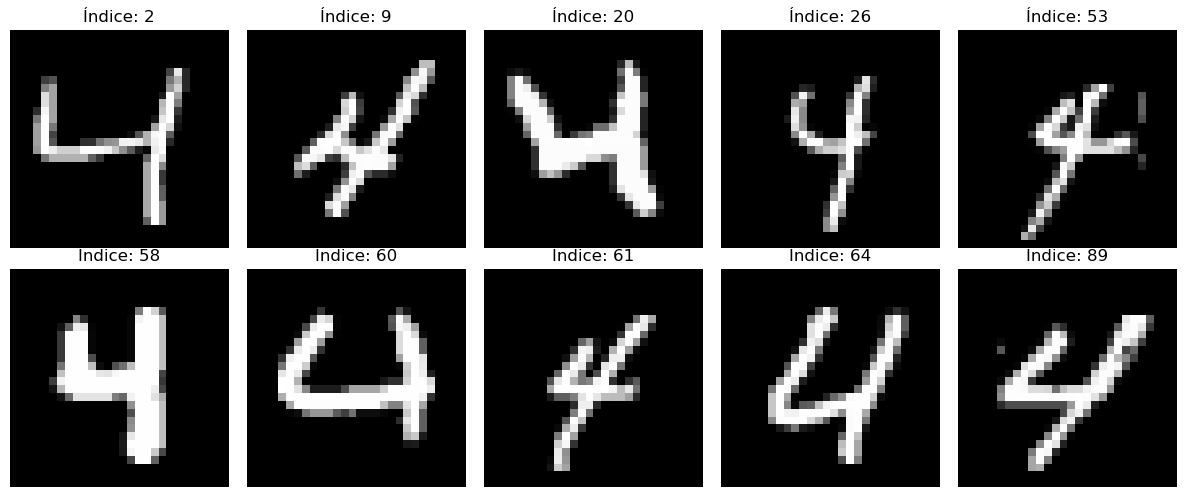

In [29]:
# Cargar el dataset MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Filtrar los índices del número 4
cuatro_indices = np.where(y_train == 4)[0]

# Mostrar las primeras 10 imágenes del número 4
plt.figure(figsize=(12, 5))
for i in range(10):
    idx = cuatro_indices[i]
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"Índice: {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [30]:
# Semillas para la reproducibilidad
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [31]:
# Seleccionamos algunos parámetros para los modelos
TAM_ENTRADA = 100  # Tamaño de la entrada para el generador
TAM_LOTE = 64
ERROR = 'binary_crossentropy'  # Función de pérdida para los modelos
LEAKY_SLOPE = 0.2  # Slope para la activación LeakyReLU
opt_d = Adam(learning_rate=0.0001, beta_1=0.5)  # Optimizador Adam para el discriminador
opt_gan = Adam(learning_rate=0.0002, beta_1=0.5)  # Optimizador Adam para la GAN y el generador

In [32]:
# El modelo generador a partir de ruido aleatorio generará imágenes
# La capa de salida tanh genera una salida entre -1 y 1, por lo tanto las imágenes deberán tener este formato
# Las capas Conv2DTranspose hacen lo contrario que una capa Conv2D, en vez de encontrar características en una imagen van dibujando características en una imagen
def crear_generador():
    modelo = Sequential()
    modelo.add(Dense(7 * 7 * 128, use_bias=False, input_shape=(TAM_ENTRADA,))) # Se crea un vector con la entrada de ruido de tamaño 7x7x128
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((7, 7, 128))) # Se convierte el vector a tamaño (7,7,128)
    modelo.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False)) # Se realiza un upsampling y nos quedamos con un vector de 14x14 de 128 canales
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False)) # Se vuelve al realizar un upsampling y nos quedamos con un vector de 28x28 de 64 canales
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Conv2DTranspose(1, kernel_size=7, strides=1, padding='same', use_bias=False, activation='tanh')) # Se reducen todos los canales a 1, quedando una imagen de 28x28
    return modelo

In [33]:
# El discriminador busca las características de una imagen y las clasifica
def crear_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(28, 28, 1), use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Dropout(0.3))
    modelo.add(Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Dropout(0.3))
    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))
    modelo.compile(optimizer=opt_d, loss=ERROR)
    return modelo


In [34]:
def crear_GAN(generador, discriminador):
    modelo = Sequential()
    # Congelamos el discriminador durante el entrenamiento del generador
    discriminador.trainable = False
    modelo.add(generador)
    modelo.add(discriminador)
    modelo.compile(optimizer=opt_gan, loss=ERROR)
    return modelo

In [35]:
# Función para cargar los datos del número 4 desde MNIST
def cargar_datos():
    print('Cargando dígitos "4" desde MNIST...', end="", flush=True)
    # Cargamos los datos de MNIST
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # Filtramos las imágenes del número 4
    cuatro_idx = np.where(y_train == 4)[0]
    x_cuatro = x_train[cuatro_idx]
    # Expandimos dimensiones para que tenga forma (28, 28, 1)
    x_cuatro = np.expand_dims(x_cuatro, axis=-1)
    # Normalizamos las imágenes entre [-1, 1]
    x_cuatro = (x_cuatro.astype(np.float32) - 127.5) / 127.5
    print('¡Listo!')
    return x_cuatro


In [36]:
# Función para ir mostrando los resultados durante el entrenamiento
def graficar_imagenes_generadas(epoch, generador, tam_lote=16):
    # Generamos un lote de ruido aleatorio para generar las imágenes
    ruido = np.random.normal(0, 1, (tam_lote, TAM_ENTRADA))
    # Generamos las imágenes a partir del ruido usando el generador
    imagenes_generadas = generador.predict(ruido)
    # Desnormalizamos las imágenes generadas para que estén en el rango [0, 1]
    imagenes_generadas = (imagenes_generadas + 1) / 2


    fig, axs = plt.subplots(4, 4, figsize=(4, 4), sharex=True, sharey=True)
    axs = axs.ravel()
    for i in range(tam_lote):
        axs[i].imshow(imagenes_generadas[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f'Imágenes generadas - Epoch {epoch}')
    plt.tight_layout()
    plt.show()


Para entrena las **Redes Adversarias** debemos llevar a cabo estos pasos:

1. Entrenar el **Discriminador**  
2. “Congelar” los coeficientes del Discriminador  
3. Entrenar únicamente el **Generador**  
4. “Descongelar” los coeficientes del Discriminador  
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar en el entrenamiento

Usaremos trin_on_batch en vez de fit porque nos permite controlar qué pasa en cada iteración

In [37]:
# Función para realizar el entrenamiento
def entrenar_gan(N_ITS):
    # Carganos los datos y creamos los modelos
    x_train = cargar_datos()
    generador = crear_generador()
    discriminador = crear_discriminador()
    gan = crear_GAN(generador, discriminador)

    # Comienza el entrenamiento de N_ITS epocs
    for i in range(1, N_ITS + 1):
        print(f"Epoch {i}")

        # Generamos un lote de ruido aleatorio para generar imágenes con el generador
        ruido = np.random.normal(0, 1, (TAM_LOTE, TAM_ENTRADA))
        imagenes_falsas = generador.predict(ruido, verbose=0)

        # Seleccionamos imágenes reales del conjunto de datos
        idx = np.random.randint(0, x_train.shape[0], TAM_LOTE)
        imagenes_reales = x_train[idx]

        # Etiquetamos las imágenes reales (1) y falsas (0)
        reales = np.ones(TAM_LOTE) * 0.9
        falsas = np.zeros(TAM_LOTE)

        # Entrenamos el discriminador con imágenes reales y falsas
        # 4
        discriminador.trainable = True
        # 1
        d_loss_real = discriminador.train_on_batch(imagenes_reales, reales)
        d_loss_fake = discriminador.train_on_batch(imagenes_falsas, falsas)

        # Entrenamos el generador
        # 2
        discriminador.trainable = False
        # 3
        g_loss = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

        # Mostramos las métricas para cada época
        print(f"  D_real: {d_loss_real:.4f}, D_fake: {d_loss_fake:.4f}, G: {g_loss:.4f}")

        # Vamos mostrando las imágenes generadas
        if i == 1 or i % 100 == 0:
            graficar_imagenes_generadas(i, generador)



Cargando dígitos "4" desde MNIST...¡Listo!
Epoch 1
  D_real: 0.5695, D_fake: 0.6449, G: 0.6339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


2025-04-23 17:39:12.523715: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


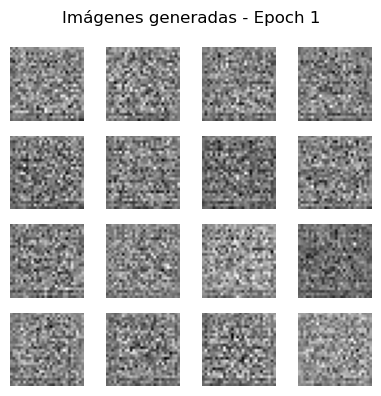

Epoch 2
  D_real: 0.5749, D_fake: 0.6625, G: 0.5206
Epoch 3
  D_real: 0.6058, D_fake: 0.6832, G: 0.4546
Epoch 4
  D_real: 0.6387, D_fake: 0.7078, G: 0.4396
Epoch 5
  D_real: 0.6708, D_fake: 0.7112, G: 0.4910
Epoch 6
  D_real: 0.6818, D_fake: 0.6925, G: 0.5257
Epoch 7
  D_real: 0.6741, D_fake: 0.6833, G: 0.5648
Epoch 8
  D_real: 0.6653, D_fake: 0.6746, G: 0.6051
Epoch 9
  D_real: 0.6582, D_fake: 0.6489, G: 0.6389
Epoch 10
  D_real: 0.6374, D_fake: 0.6287, G: 0.6942
Epoch 11
  D_real: 0.6185, D_fake: 0.6129, G: 0.7510
Epoch 12
  D_real: 0.6055, D_fake: 0.5931, G: 0.7853
Epoch 13
  D_real: 0.5856, D_fake: 0.5777, G: 0.8125
Epoch 14
  D_real: 0.5728, D_fake: 0.5639, G: 0.8460
Epoch 15
  D_real: 0.5584, D_fake: 0.5497, G: 0.8862
Epoch 16
  D_real: 0.5449, D_fake: 0.5373, G: 0.9274
Epoch 17
  D_real: 0.5341, D_fake: 0.5262, G: 0.9708
Epoch 18
  D_real: 0.5231, D_fake: 0.5165, G: 1.0004
Epoch 19
  D_real: 0.5137, D_fake: 0.5064, G: 1.0431
Epoch 20
  D_real: 0.5046, D_fake: 0.4982, G: 1.0728
E

2025-04-23 17:39:25.152049: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


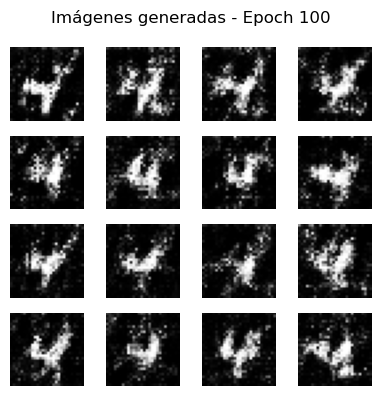

Epoch 101
  D_real: 0.5672, D_fake: 0.5682, G: 1.4521
Epoch 102
  D_real: 0.5706, D_fake: 0.5711, G: 1.4491
Epoch 103
  D_real: 0.5741, D_fake: 0.5744, G: 1.4472
Epoch 104
  D_real: 0.5759, D_fake: 0.5763, G: 1.4449
Epoch 105
  D_real: 0.5780, D_fake: 0.5777, G: 1.4439
Epoch 106
  D_real: 0.5794, D_fake: 0.5790, G: 1.4411
Epoch 107
  D_real: 0.5805, D_fake: 0.5813, G: 1.4379
Epoch 108
  D_real: 0.5824, D_fake: 0.5826, G: 1.4351
Epoch 109
  D_real: 0.5841, D_fake: 0.5847, G: 1.4328
Epoch 110
  D_real: 0.5863, D_fake: 0.5861, G: 1.4315
Epoch 111
  D_real: 0.5875, D_fake: 0.5882, G: 1.4295
Epoch 112
  D_real: 0.5899, D_fake: 0.5896, G: 1.4289
Epoch 113
  D_real: 0.5913, D_fake: 0.5909, G: 1.4292
Epoch 114
  D_real: 0.5922, D_fake: 0.5915, G: 1.4287
Epoch 115
  D_real: 0.5925, D_fake: 0.5926, G: 1.4265
Epoch 116
  D_real: 0.5937, D_fake: 0.5933, G: 1.4246
Epoch 117
  D_real: 0.5941, D_fake: 0.5947, G: 1.4215
Epoch 118
  D_real: 0.5957, D_fake: 0.5956, G: 1.4184
Epoch 119
  D_real: 0.5974, 

2025-04-23 17:39:38.155242: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


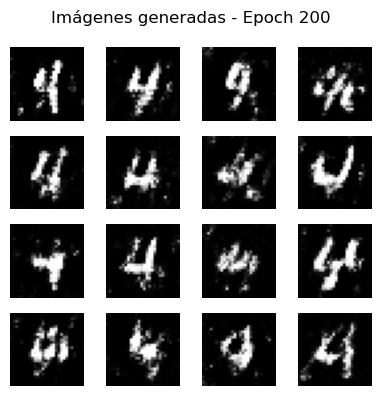

Epoch 201
  D_real: 0.6712, D_fake: 0.6712, G: 1.2837
Epoch 202
  D_real: 0.6718, D_fake: 0.6720, G: 1.2823
Epoch 203
  D_real: 0.6725, D_fake: 0.6725, G: 1.2811
Epoch 204
  D_real: 0.6731, D_fake: 0.6731, G: 1.2797
Epoch 205
  D_real: 0.6735, D_fake: 0.6734, G: 1.2784
Epoch 206
  D_real: 0.6740, D_fake: 0.6739, G: 1.2778
Epoch 207
  D_real: 0.6740, D_fake: 0.6738, G: 1.2769
Epoch 208
  D_real: 0.6743, D_fake: 0.6741, G: 1.2760
Epoch 209
  D_real: 0.6746, D_fake: 0.6746, G: 1.2750
Epoch 210
  D_real: 0.6751, D_fake: 0.6749, G: 1.2742
Epoch 211
  D_real: 0.6757, D_fake: 0.6757, G: 1.2724
Epoch 212
  D_real: 0.6760, D_fake: 0.6761, G: 1.2707
Epoch 213
  D_real: 0.6764, D_fake: 0.6765, G: 1.2693
Epoch 214
  D_real: 0.6773, D_fake: 0.6778, G: 1.2682
Epoch 215
  D_real: 0.6785, D_fake: 0.6781, G: 1.2671
Epoch 216
  D_real: 0.6787, D_fake: 0.6788, G: 1.2658
Epoch 217
  D_real: 0.6793, D_fake: 0.6793, G: 1.2650
Epoch 218
  D_real: 0.6797, D_fake: 0.6796, G: 1.2641
Epoch 219
  D_real: 0.6801, 

2025-04-23 17:39:50.425140: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


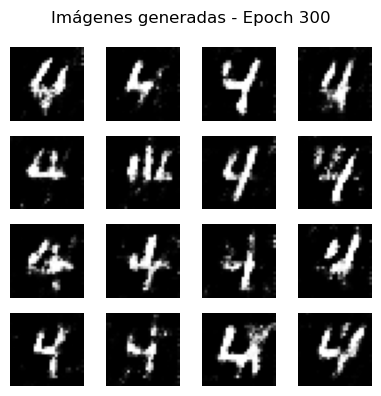

Epoch 301
  D_real: 0.7067, D_fake: 0.7065, G: 1.1957
Epoch 302
  D_real: 0.7067, D_fake: 0.7066, G: 1.1949
Epoch 303
  D_real: 0.7067, D_fake: 0.7066, G: 1.1940
Epoch 304
  D_real: 0.7069, D_fake: 0.7070, G: 1.1930
Epoch 305
  D_real: 0.7073, D_fake: 0.7072, G: 1.1923
Epoch 306
  D_real: 0.7075, D_fake: 0.7075, G: 1.1918
Epoch 307
  D_real: 0.7077, D_fake: 0.7077, G: 1.1912
Epoch 308
  D_real: 0.7080, D_fake: 0.7081, G: 1.1908
Epoch 309
  D_real: 0.7083, D_fake: 0.7082, G: 1.1902
Epoch 310
  D_real: 0.7085, D_fake: 0.7084, G: 1.1896
Epoch 311
  D_real: 0.7086, D_fake: 0.7088, G: 1.1888
Epoch 312
  D_real: 0.7090, D_fake: 0.7091, G: 1.1884
Epoch 313
  D_real: 0.7094, D_fake: 0.7092, G: 1.1877
Epoch 314
  D_real: 0.7094, D_fake: 0.7092, G: 1.1874
Epoch 315
  D_real: 0.7096, D_fake: 0.7095, G: 1.1873
Epoch 316
  D_real: 0.7095, D_fake: 0.7094, G: 1.1867
Epoch 317
  D_real: 0.7097, D_fake: 0.7095, G: 1.1863
Epoch 318
  D_real: 0.7098, D_fake: 0.7096, G: 1.1858
Epoch 319
  D_real: 0.7099, 

2025-04-23 17:40:02.896077: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


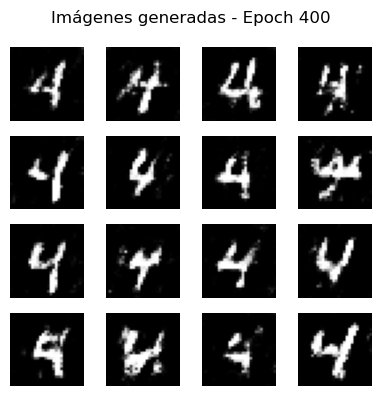

Epoch 401
  D_real: 0.7198, D_fake: 0.7197, G: 1.1491
Epoch 402
  D_real: 0.7199, D_fake: 0.7197, G: 1.1489
Epoch 403
  D_real: 0.7199, D_fake: 0.7197, G: 1.1487
Epoch 404
  D_real: 0.7199, D_fake: 0.7197, G: 1.1481
Epoch 405
  D_real: 0.7198, D_fake: 0.7199, G: 1.1477
Epoch 406
  D_real: 0.7200, D_fake: 0.7202, G: 1.1472
Epoch 407
  D_real: 0.7203, D_fake: 0.7202, G: 1.1469
Epoch 408
  D_real: 0.7202, D_fake: 0.7201, G: 1.1469
Epoch 409
  D_real: 0.7203, D_fake: 0.7201, G: 1.1465
Epoch 410
  D_real: 0.7203, D_fake: 0.7201, G: 1.1463
Epoch 411
  D_real: 0.7203, D_fake: 0.7202, G: 1.1461
Epoch 412
  D_real: 0.7203, D_fake: 0.7202, G: 1.1458
Epoch 413
  D_real: 0.7203, D_fake: 0.7202, G: 1.1453
Epoch 414
  D_real: 0.7204, D_fake: 0.7203, G: 1.1451
Epoch 415
  D_real: 0.7206, D_fake: 0.7204, G: 1.1448
Epoch 416
  D_real: 0.7207, D_fake: 0.7206, G: 1.1447
Epoch 417
  D_real: 0.7208, D_fake: 0.7207, G: 1.1445
Epoch 418
  D_real: 0.7208, D_fake: 0.7207, G: 1.1443
Epoch 419
  D_real: 0.7207, 

2025-04-23 17:40:15.663787: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


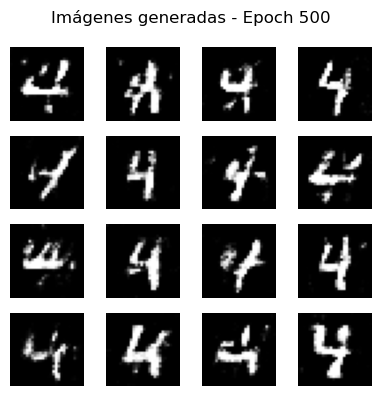

Epoch 501
  D_real: 0.7245, D_fake: 0.7244, G: 1.1199
Epoch 502
  D_real: 0.7244, D_fake: 0.7242, G: 1.1199
Epoch 503
  D_real: 0.7243, D_fake: 0.7241, G: 1.1197
Epoch 504
  D_real: 0.7242, D_fake: 0.7241, G: 1.1194
Epoch 505
  D_real: 0.7242, D_fake: 0.7240, G: 1.1191
Epoch 506
  D_real: 0.7241, D_fake: 0.7241, G: 1.1189
Epoch 507
  D_real: 0.7242, D_fake: 0.7241, G: 1.1185
Epoch 508
  D_real: 0.7241, D_fake: 0.7241, G: 1.1182
Epoch 509
  D_real: 0.7242, D_fake: 0.7241, G: 1.1177
Epoch 510
  D_real: 0.7243, D_fake: 0.7243, G: 1.1174
Epoch 511
  D_real: 0.7244, D_fake: 0.7243, G: 1.1171
Epoch 512
  D_real: 0.7244, D_fake: 0.7243, G: 1.1170
Epoch 513
  D_real: 0.7244, D_fake: 0.7243, G: 1.1167
Epoch 514
  D_real: 0.7244, D_fake: 0.7243, G: 1.1165
Epoch 515
  D_real: 0.7244, D_fake: 0.7243, G: 1.1166
Epoch 516
  D_real: 0.7244, D_fake: 0.7242, G: 1.1165
Epoch 517
  D_real: 0.7244, D_fake: 0.7243, G: 1.1166
Epoch 518
  D_real: 0.7243, D_fake: 0.7241, G: 1.1165
Epoch 519
  D_real: 0.7241, 

2025-04-23 17:40:28.458014: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


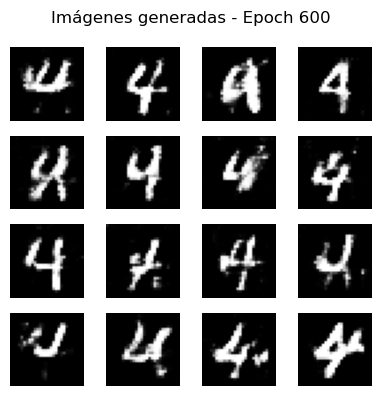

Epoch 601
  D_real: 0.7252, D_fake: 0.7251, G: 1.1007
Epoch 602
  D_real: 0.7252, D_fake: 0.7250, G: 1.1005
Epoch 603
  D_real: 0.7252, D_fake: 0.7251, G: 1.1004
Epoch 604
  D_real: 0.7252, D_fake: 0.7251, G: 1.1003
Epoch 605
  D_real: 0.7252, D_fake: 0.7250, G: 1.1001
Epoch 606
  D_real: 0.7251, D_fake: 0.7250, G: 1.1000
Epoch 607
  D_real: 0.7251, D_fake: 0.7249, G: 1.1001
Epoch 608
  D_real: 0.7250, D_fake: 0.7249, G: 1.0999
Epoch 609
  D_real: 0.7250, D_fake: 0.7249, G: 1.0998
Epoch 610
  D_real: 0.7249, D_fake: 0.7249, G: 1.0998
Epoch 611
  D_real: 0.7248, D_fake: 0.7248, G: 1.0997
Epoch 612
  D_real: 0.7249, D_fake: 0.7248, G: 1.0997
Epoch 613
  D_real: 0.7249, D_fake: 0.7248, G: 1.0998
Epoch 614
  D_real: 0.7248, D_fake: 0.7248, G: 1.0995
Epoch 615
  D_real: 0.7248, D_fake: 0.7247, G: 1.0991
Epoch 616
  D_real: 0.7248, D_fake: 0.7248, G: 1.0989
Epoch 617
  D_real: 0.7249, D_fake: 0.7248, G: 1.0988
Epoch 618
  D_real: 0.7249, D_fake: 0.7249, G: 1.0986
Epoch 619
  D_real: 0.7251, 

2025-04-23 17:40:40.823864: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


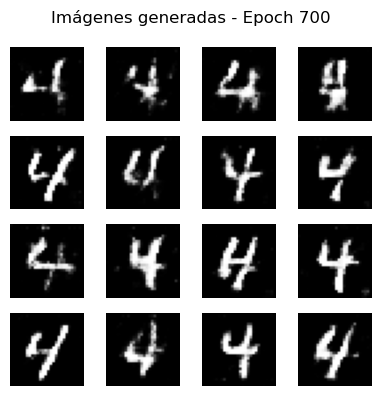

Epoch 701
  D_real: 0.7248, D_fake: 0.7246, G: 1.0880
Epoch 702
  D_real: 0.7247, D_fake: 0.7245, G: 1.0880
Epoch 703
  D_real: 0.7245, D_fake: 0.7243, G: 1.0879
Epoch 704
  D_real: 0.7243, D_fake: 0.7243, G: 1.0877
Epoch 705
  D_real: 0.7243, D_fake: 0.7243, G: 1.0877
Epoch 706
  D_real: 0.7244, D_fake: 0.7242, G: 1.0877
Epoch 707
  D_real: 0.7242, D_fake: 0.7242, G: 1.0876
Epoch 708
  D_real: 0.7243, D_fake: 0.7242, G: 1.0874
Epoch 709
  D_real: 0.7243, D_fake: 0.7242, G: 1.0872
Epoch 710
  D_real: 0.7243, D_fake: 0.7242, G: 1.0871
Epoch 711
  D_real: 0.7242, D_fake: 0.7242, G: 1.0869
Epoch 712
  D_real: 0.7243, D_fake: 0.7242, G: 1.0866
Epoch 713
  D_real: 0.7242, D_fake: 0.7241, G: 1.0865
Epoch 714
  D_real: 0.7242, D_fake: 0.7242, G: 1.0866
Epoch 715
  D_real: 0.7244, D_fake: 0.7242, G: 1.0867
Epoch 716
  D_real: 0.7243, D_fake: 0.7242, G: 1.0868
Epoch 717
  D_real: 0.7242, D_fake: 0.7241, G: 1.0869
Epoch 718
  D_real: 0.7241, D_fake: 0.7240, G: 1.0869
Epoch 719
  D_real: 0.7240, 

2025-04-23 17:40:53.441336: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


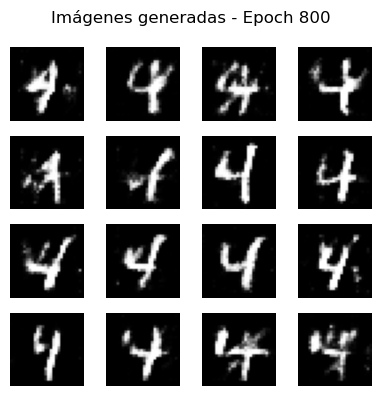

Epoch 801
  D_real: 0.7230, D_fake: 0.7230, G: 1.0794
Epoch 802
  D_real: 0.7231, D_fake: 0.7230, G: 1.0793
Epoch 803
  D_real: 0.7230, D_fake: 0.7230, G: 1.0792
Epoch 804
  D_real: 0.7230, D_fake: 0.7229, G: 1.0793
Epoch 805
  D_real: 0.7230, D_fake: 0.7229, G: 1.0793
Epoch 806
  D_real: 0.7229, D_fake: 0.7228, G: 1.0792
Epoch 807
  D_real: 0.7229, D_fake: 0.7227, G: 1.0791
Epoch 808
  D_real: 0.7228, D_fake: 0.7227, G: 1.0790
Epoch 809
  D_real: 0.7226, D_fake: 0.7226, G: 1.0788
Epoch 810
  D_real: 0.7227, D_fake: 0.7226, G: 1.0788
Epoch 811
  D_real: 0.7227, D_fake: 0.7226, G: 1.0787
Epoch 812
  D_real: 0.7226, D_fake: 0.7226, G: 1.0787
Epoch 813
  D_real: 0.7227, D_fake: 0.7227, G: 1.0786
Epoch 814
  D_real: 0.7228, D_fake: 0.7227, G: 1.0785
Epoch 815
  D_real: 0.7228, D_fake: 0.7226, G: 1.0785
Epoch 816
  D_real: 0.7226, D_fake: 0.7225, G: 1.0784
Epoch 817
  D_real: 0.7226, D_fake: 0.7225, G: 1.0783
Epoch 818
  D_real: 0.7224, D_fake: 0.7224, G: 1.0783
Epoch 819
  D_real: 0.7224, 

2025-04-23 17:41:06.494677: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


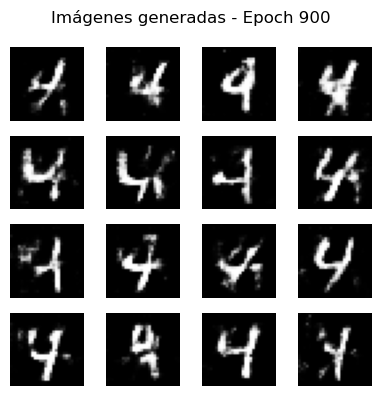

Epoch 901
  D_real: 0.7212, D_fake: 0.7211, G: 1.0732
Epoch 902
  D_real: 0.7211, D_fake: 0.7209, G: 1.0733
Epoch 903
  D_real: 0.7209, D_fake: 0.7208, G: 1.0732
Epoch 904
  D_real: 0.7208, D_fake: 0.7208, G: 1.0731
Epoch 905
  D_real: 0.7208, D_fake: 0.7208, G: 1.0730
Epoch 906
  D_real: 0.7208, D_fake: 0.7208, G: 1.0729
Epoch 907
  D_real: 0.7209, D_fake: 0.7209, G: 1.0727
Epoch 908
  D_real: 0.7209, D_fake: 0.7209, G: 1.0725
Epoch 909
  D_real: 0.7210, D_fake: 0.7209, G: 1.0723
Epoch 910
  D_real: 0.7211, D_fake: 0.7210, G: 1.0723
Epoch 911
  D_real: 0.7211, D_fake: 0.7210, G: 1.0723
Epoch 912
  D_real: 0.7211, D_fake: 0.7209, G: 1.0723
Epoch 913
  D_real: 0.7210, D_fake: 0.7208, G: 1.0721
Epoch 914
  D_real: 0.7209, D_fake: 0.7208, G: 1.0720
Epoch 915
  D_real: 0.7208, D_fake: 0.7209, G: 1.0720
Epoch 916
  D_real: 0.7210, D_fake: 0.7211, G: 1.0719
Epoch 917
  D_real: 0.7212, D_fake: 0.7211, G: 1.0718
Epoch 918
  D_real: 0.7213, D_fake: 0.7212, G: 1.0718
Epoch 919
  D_real: 0.7212, 

2025-04-23 17:41:19.695691: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


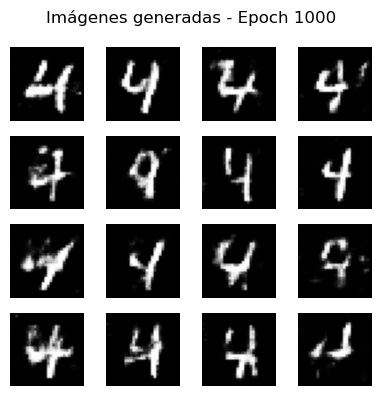

Epoch 1001
  D_real: 0.7195, D_fake: 0.7194, G: 1.0680
Epoch 1002
  D_real: 0.7194, D_fake: 0.7193, G: 1.0680
Epoch 1003
  D_real: 0.7193, D_fake: 0.7192, G: 1.0679
Epoch 1004
  D_real: 0.7192, D_fake: 0.7192, G: 1.0677
Epoch 1005
  D_real: 0.7192, D_fake: 0.7193, G: 1.0675
Epoch 1006
  D_real: 0.7194, D_fake: 0.7195, G: 1.0674
Epoch 1007
  D_real: 0.7195, D_fake: 0.7195, G: 1.0673
Epoch 1008
  D_real: 0.7196, D_fake: 0.7195, G: 1.0672
Epoch 1009
  D_real: 0.7196, D_fake: 0.7195, G: 1.0672
Epoch 1010
  D_real: 0.7195, D_fake: 0.7195, G: 1.0671
Epoch 1011
  D_real: 0.7195, D_fake: 0.7193, G: 1.0673
Epoch 1012
  D_real: 0.7193, D_fake: 0.7191, G: 1.0676
Epoch 1013
  D_real: 0.7192, D_fake: 0.7190, G: 1.0677
Epoch 1014
  D_real: 0.7189, D_fake: 0.7188, G: 1.0678
Epoch 1015
  D_real: 0.7188, D_fake: 0.7187, G: 1.0677
Epoch 1016
  D_real: 0.7187, D_fake: 0.7186, G: 1.0677
Epoch 1017
  D_real: 0.7187, D_fake: 0.7187, G: 1.0675
Epoch 1018
  D_real: 0.7187, D_fake: 0.7187, G: 1.0674
Epoch 1019

2025-04-23 17:41:32.274852: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


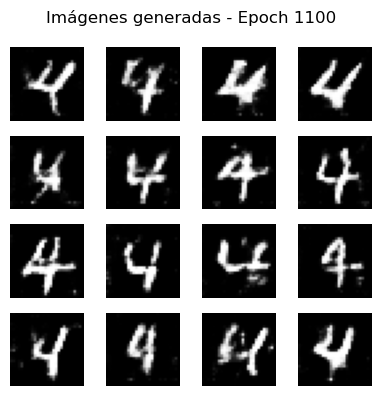

Epoch 1101
  D_real: 0.7166, D_fake: 0.7166, G: 1.0646
Epoch 1102
  D_real: 0.7166, D_fake: 0.7166, G: 1.0644
Epoch 1103
  D_real: 0.7166, D_fake: 0.7166, G: 1.0643
Epoch 1104
  D_real: 0.7167, D_fake: 0.7166, G: 1.0643
Epoch 1105
  D_real: 0.7166, D_fake: 0.7165, G: 1.0643
Epoch 1106
  D_real: 0.7165, D_fake: 0.7164, G: 1.0642
Epoch 1107
  D_real: 0.7164, D_fake: 0.7164, G: 1.0641
Epoch 1108
  D_real: 0.7164, D_fake: 0.7163, G: 1.0641
Epoch 1109
  D_real: 0.7164, D_fake: 0.7162, G: 1.0641
Epoch 1110
  D_real: 0.7162, D_fake: 0.7162, G: 1.0641
Epoch 1111
  D_real: 0.7162, D_fake: 0.7161, G: 1.0641
Epoch 1112
  D_real: 0.7161, D_fake: 0.7161, G: 1.0640
Epoch 1113
  D_real: 0.7161, D_fake: 0.7160, G: 1.0639
Epoch 1114
  D_real: 0.7161, D_fake: 0.7160, G: 1.0638
Epoch 1115
  D_real: 0.7160, D_fake: 0.7159, G: 1.0639
Epoch 1116
  D_real: 0.7160, D_fake: 0.7159, G: 1.0638
Epoch 1117
  D_real: 0.7160, D_fake: 0.7159, G: 1.0639
Epoch 1118
  D_real: 0.7159, D_fake: 0.7158, G: 1.0639
Epoch 1119

2025-04-23 17:41:45.186331: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


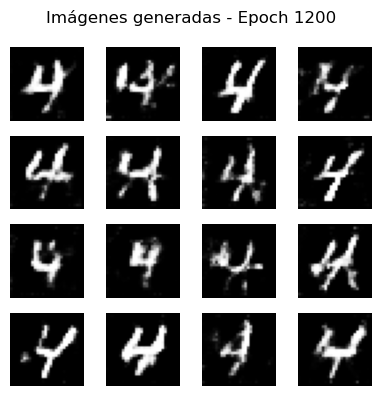

Epoch 1201
  D_real: 0.7149, D_fake: 0.7148, G: 1.0595
Epoch 1202
  D_real: 0.7149, D_fake: 0.7148, G: 1.0596
Epoch 1203
  D_real: 0.7148, D_fake: 0.7146, G: 1.0597
Epoch 1204
  D_real: 0.7147, D_fake: 0.7145, G: 1.0599
Epoch 1205
  D_real: 0.7145, D_fake: 0.7145, G: 1.0598
Epoch 1206
  D_real: 0.7145, D_fake: 0.7145, G: 1.0597
Epoch 1207
  D_real: 0.7145, D_fake: 0.7146, G: 1.0595
Epoch 1208
  D_real: 0.7146, D_fake: 0.7147, G: 1.0594
Epoch 1209
  D_real: 0.7147, D_fake: 0.7147, G: 1.0593
Epoch 1210
  D_real: 0.7148, D_fake: 0.7147, G: 1.0593
Epoch 1211
  D_real: 0.7147, D_fake: 0.7146, G: 1.0593
Epoch 1212
  D_real: 0.7147, D_fake: 0.7146, G: 1.0594
Epoch 1213
  D_real: 0.7146, D_fake: 0.7145, G: 1.0595
Epoch 1214
  D_real: 0.7146, D_fake: 0.7144, G: 1.0597
Epoch 1215
  D_real: 0.7144, D_fake: 0.7143, G: 1.0596
Epoch 1216
  D_real: 0.7143, D_fake: 0.7143, G: 1.0595
Epoch 1217
  D_real: 0.7143, D_fake: 0.7142, G: 1.0594
Epoch 1218
  D_real: 0.7142, D_fake: 0.7141, G: 1.0593
Epoch 1219

2025-04-23 17:41:57.834544: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


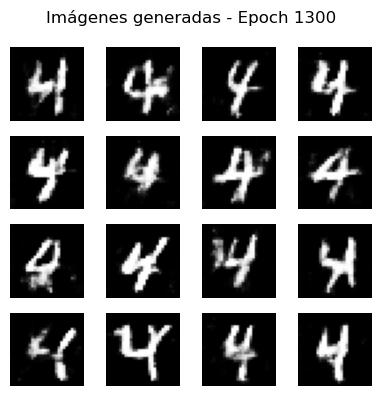

Epoch 1301
  D_real: 0.7116, D_fake: 0.7116, G: 1.0563
Epoch 1302
  D_real: 0.7117, D_fake: 0.7117, G: 1.0562
Epoch 1303
  D_real: 0.7118, D_fake: 0.7119, G: 1.0560
Epoch 1304
  D_real: 0.7120, D_fake: 0.7120, G: 1.0560
Epoch 1305
  D_real: 0.7120, D_fake: 0.7120, G: 1.0560
Epoch 1306
  D_real: 0.7120, D_fake: 0.7119, G: 1.0560
Epoch 1307
  D_real: 0.7119, D_fake: 0.7120, G: 1.0559
Epoch 1308
  D_real: 0.7120, D_fake: 0.7119, G: 1.0558
Epoch 1309
  D_real: 0.7120, D_fake: 0.7119, G: 1.0559
Epoch 1310
  D_real: 0.7119, D_fake: 0.7118, G: 1.0559
Epoch 1311
  D_real: 0.7118, D_fake: 0.7117, G: 1.0559
Epoch 1312
  D_real: 0.7117, D_fake: 0.7116, G: 1.0559
Epoch 1313
  D_real: 0.7116, D_fake: 0.7116, G: 1.0558
Epoch 1314
  D_real: 0.7116, D_fake: 0.7115, G: 1.0559
Epoch 1315
  D_real: 0.7115, D_fake: 0.7114, G: 1.0560
Epoch 1316
  D_real: 0.7114, D_fake: 0.7113, G: 1.0560
Epoch 1317
  D_real: 0.7113, D_fake: 0.7113, G: 1.0559
Epoch 1318
  D_real: 0.7113, D_fake: 0.7114, G: 1.0557
Epoch 1319

2025-04-23 17:42:10.563605: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


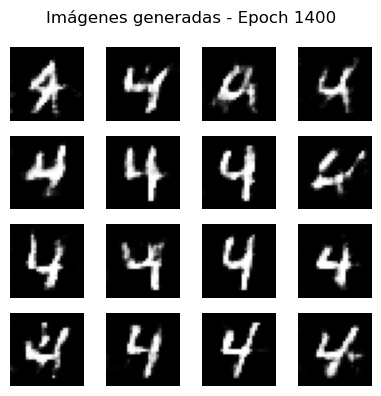

Epoch 1401
  D_real: 0.7100, D_fake: 0.7099, G: 1.0538
Epoch 1402
  D_real: 0.7099, D_fake: 0.7098, G: 1.0538
Epoch 1403
  D_real: 0.7098, D_fake: 0.7097, G: 1.0537
Epoch 1404
  D_real: 0.7097, D_fake: 0.7097, G: 1.0536
Epoch 1405
  D_real: 0.7097, D_fake: 0.7097, G: 1.0535
Epoch 1406
  D_real: 0.7097, D_fake: 0.7097, G: 1.0533
Epoch 1407
  D_real: 0.7098, D_fake: 0.7099, G: 1.0531
Epoch 1408
  D_real: 0.7100, D_fake: 0.7100, G: 1.0531
Epoch 1409
  D_real: 0.7100, D_fake: 0.7101, G: 1.0530
Epoch 1410
  D_real: 0.7102, D_fake: 0.7101, G: 1.0530
Epoch 1411
  D_real: 0.7102, D_fake: 0.7100, G: 1.0533
Epoch 1412
  D_real: 0.7100, D_fake: 0.7099, G: 1.0534
Epoch 1413
  D_real: 0.7099, D_fake: 0.7097, G: 1.0537
Epoch 1414
  D_real: 0.7096, D_fake: 0.7095, G: 1.0538
Epoch 1415
  D_real: 0.7095, D_fake: 0.7094, G: 1.0539
Epoch 1416
  D_real: 0.7093, D_fake: 0.7094, G: 1.0537
Epoch 1417
  D_real: 0.7094, D_fake: 0.7095, G: 1.0534
Epoch 1418
  D_real: 0.7095, D_fake: 0.7095, G: 1.0532
Epoch 1419

2025-04-23 17:42:23.692523: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


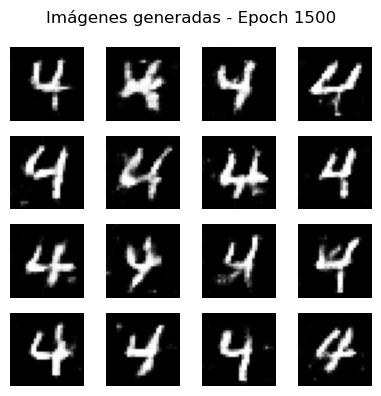

Epoch 1501
  D_real: 0.7068, D_fake: 0.7067, G: 1.0529
Epoch 1502
  D_real: 0.7067, D_fake: 0.7067, G: 1.0528
Epoch 1503
  D_real: 0.7067, D_fake: 0.7067, G: 1.0527
Epoch 1504
  D_real: 0.7067, D_fake: 0.7067, G: 1.0527
Epoch 1505
  D_real: 0.7067, D_fake: 0.7067, G: 1.0526
Epoch 1506
  D_real: 0.7067, D_fake: 0.7066, G: 1.0526
Epoch 1507
  D_real: 0.7067, D_fake: 0.7066, G: 1.0526
Epoch 1508
  D_real: 0.7066, D_fake: 0.7066, G: 1.0527
Epoch 1509
  D_real: 0.7066, D_fake: 0.7065, G: 1.0527
Epoch 1510
  D_real: 0.7065, D_fake: 0.7064, G: 1.0527
Epoch 1511
  D_real: 0.7064, D_fake: 0.7064, G: 1.0526
Epoch 1512
  D_real: 0.7063, D_fake: 0.7063, G: 1.0525
Epoch 1513
  D_real: 0.7064, D_fake: 0.7064, G: 1.0524
Epoch 1514
  D_real: 0.7064, D_fake: 0.7064, G: 1.0523
Epoch 1515
  D_real: 0.7065, D_fake: 0.7065, G: 1.0522
Epoch 1516
  D_real: 0.7065, D_fake: 0.7064, G: 1.0522
Epoch 1517
  D_real: 0.7065, D_fake: 0.7064, G: 1.0523
Epoch 1518
  D_real: 0.7064, D_fake: 0.7063, G: 1.0524
Epoch 1519

2025-04-23 17:42:36.530461: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


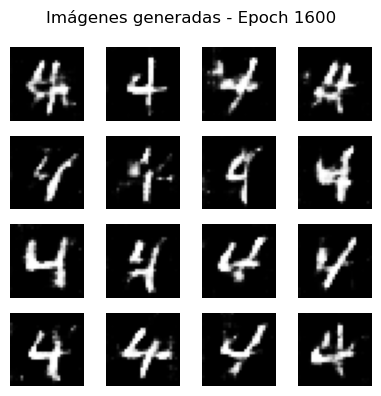

Epoch 1601
  D_real: 0.7031, D_fake: 0.7030, G: 1.0530
Epoch 1602
  D_real: 0.7030, D_fake: 0.7028, G: 1.0532
Epoch 1603
  D_real: 0.7028, D_fake: 0.7026, G: 1.0535
Epoch 1604
  D_real: 0.7026, D_fake: 0.7024, G: 1.0537
Epoch 1605
  D_real: 0.7024, D_fake: 0.7024, G: 1.0537
Epoch 1606
  D_real: 0.7023, D_fake: 0.7023, G: 1.0536
Epoch 1607
  D_real: 0.7023, D_fake: 0.7023, G: 1.0535
Epoch 1608
  D_real: 0.7023, D_fake: 0.7023, G: 1.0534
Epoch 1609
  D_real: 0.7023, D_fake: 0.7023, G: 1.0534
Epoch 1610
  D_real: 0.7022, D_fake: 0.7021, G: 1.0534
Epoch 1611
  D_real: 0.7022, D_fake: 0.7021, G: 1.0535
Epoch 1612
  D_real: 0.7022, D_fake: 0.7021, G: 1.0534
Epoch 1613
  D_real: 0.7022, D_fake: 0.7021, G: 1.0533
Epoch 1614
  D_real: 0.7022, D_fake: 0.7022, G: 1.0532
Epoch 1615
  D_real: 0.7022, D_fake: 0.7022, G: 1.0531
Epoch 1616
  D_real: 0.7022, D_fake: 0.7021, G: 1.0532
Epoch 1617
  D_real: 0.7021, D_fake: 0.7021, G: 1.0533
Epoch 1618
  D_real: 0.7021, D_fake: 0.7021, G: 1.0534
Epoch 1619

2025-04-23 17:42:49.239186: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


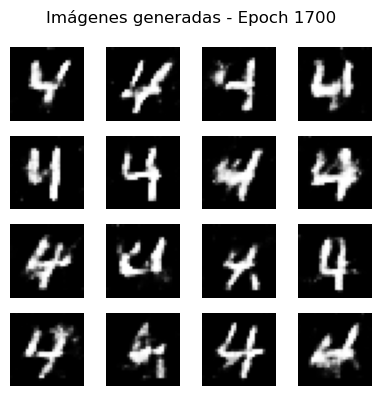

Epoch 1701
  D_real: 0.7003, D_fake: 0.7003, G: 1.0522
Epoch 1702
  D_real: 0.7003, D_fake: 0.7002, G: 1.0522
Epoch 1703
  D_real: 0.7002, D_fake: 0.7001, G: 1.0524
Epoch 1704
  D_real: 0.7001, D_fake: 0.7001, G: 1.0523
Epoch 1705
  D_real: 0.7001, D_fake: 0.7001, G: 1.0523
Epoch 1706
  D_real: 0.7001, D_fake: 0.7001, G: 1.0522
Epoch 1707
  D_real: 0.7001, D_fake: 0.7001, G: 1.0522
Epoch 1708
  D_real: 0.7000, D_fake: 0.7000, G: 1.0522
Epoch 1709
  D_real: 0.7001, D_fake: 0.7000, G: 1.0523
Epoch 1710
  D_real: 0.7000, D_fake: 0.7000, G: 1.0522
Epoch 1711
  D_real: 0.7000, D_fake: 0.7000, G: 1.0521
Epoch 1712
  D_real: 0.7000, D_fake: 0.7000, G: 1.0520
Epoch 1713
  D_real: 0.7001, D_fake: 0.7000, G: 1.0521
Epoch 1714
  D_real: 0.7000, D_fake: 0.7000, G: 1.0520
Epoch 1715
  D_real: 0.7001, D_fake: 0.7000, G: 1.0520
Epoch 1716
  D_real: 0.7000, D_fake: 0.7000, G: 1.0521
Epoch 1717
  D_real: 0.7000, D_fake: 0.6999, G: 1.0521
Epoch 1718
  D_real: 0.6999, D_fake: 0.6999, G: 1.0521
Epoch 1719

2025-04-23 17:43:01.954609: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


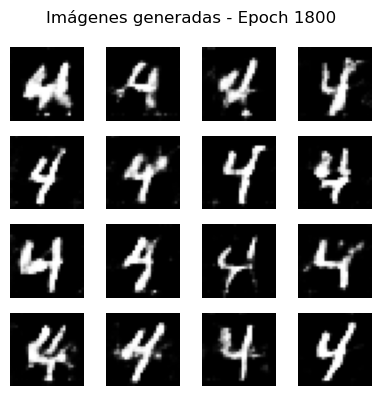

Epoch 1801
  D_real: 0.6981, D_fake: 0.6981, G: 1.0508
Epoch 1802
  D_real: 0.6981, D_fake: 0.6982, G: 1.0506
Epoch 1803
  D_real: 0.6983, D_fake: 0.6983, G: 1.0506
Epoch 1804
  D_real: 0.6983, D_fake: 0.6983, G: 1.0506
Epoch 1805
  D_real: 0.6983, D_fake: 0.6982, G: 1.0507
Epoch 1806
  D_real: 0.6982, D_fake: 0.6981, G: 1.0509
Epoch 1807
  D_real: 0.6981, D_fake: 0.6979, G: 1.0513
Epoch 1808
  D_real: 0.6979, D_fake: 0.6978, G: 1.0514
Epoch 1809
  D_real: 0.6978, D_fake: 0.6977, G: 1.0515
Epoch 1810
  D_real: 0.6977, D_fake: 0.6977, G: 1.0514
Epoch 1811
  D_real: 0.6976, D_fake: 0.6977, G: 1.0513
Epoch 1812
  D_real: 0.6976, D_fake: 0.6976, G: 1.0513
Epoch 1813
  D_real: 0.6977, D_fake: 0.6976, G: 1.0514
Epoch 1814
  D_real: 0.6976, D_fake: 0.6976, G: 1.0513
Epoch 1815
  D_real: 0.6976, D_fake: 0.6975, G: 1.0514
Epoch 1816
  D_real: 0.6975, D_fake: 0.6974, G: 1.0515
Epoch 1817
  D_real: 0.6974, D_fake: 0.6973, G: 1.0515
Epoch 1818
  D_real: 0.6973, D_fake: 0.6973, G: 1.0514
Epoch 1819

2025-04-23 17:43:14.611431: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


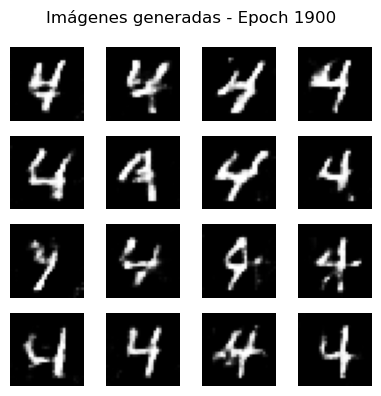

Epoch 1901
  D_real: 0.6953, D_fake: 0.6952, G: 1.0511
Epoch 1902
  D_real: 0.6952, D_fake: 0.6951, G: 1.0512
Epoch 1903
  D_real: 0.6950, D_fake: 0.6950, G: 1.0511
Epoch 1904
  D_real: 0.6949, D_fake: 0.6949, G: 1.0510
Epoch 1905
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1906
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1907
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1908
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1909
  D_real: 0.6950, D_fake: 0.6950, G: 1.0509
Epoch 1910
  D_real: 0.6950, D_fake: 0.6949, G: 1.0509
Epoch 1911
  D_real: 0.6949, D_fake: 0.6949, G: 1.0509
Epoch 1912
  D_real: 0.6949, D_fake: 0.6948, G: 1.0509
Epoch 1913
  D_real: 0.6948, D_fake: 0.6949, G: 1.0508
Epoch 1914
  D_real: 0.6949, D_fake: 0.6950, G: 1.0507
Epoch 1915
  D_real: 0.6950, D_fake: 0.6951, G: 1.0505
Epoch 1916
  D_real: 0.6952, D_fake: 0.6952, G: 1.0504
Epoch 1917
  D_real: 0.6953, D_fake: 0.6952, G: 1.0505
Epoch 1918
  D_real: 0.6953, D_fake: 0.6953, G: 1.0505
Epoch 1919

2025-04-23 17:43:27.314405: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


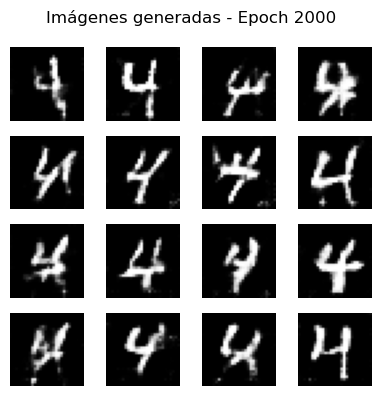

Epoch 2001
  D_real: 0.6930, D_fake: 0.6930, G: 1.0508
Epoch 2002
  D_real: 0.6929, D_fake: 0.6929, G: 1.0507
Epoch 2003
  D_real: 0.6930, D_fake: 0.6930, G: 1.0506
Epoch 2004
  D_real: 0.6931, D_fake: 0.6931, G: 1.0507
Epoch 2005
  D_real: 0.6931, D_fake: 0.6930, G: 1.0508
Epoch 2006
  D_real: 0.6930, D_fake: 0.6930, G: 1.0508
Epoch 2007
  D_real: 0.6930, D_fake: 0.6929, G: 1.0510
Epoch 2008
  D_real: 0.6929, D_fake: 0.6928, G: 1.0510
Epoch 2009
  D_real: 0.6928, D_fake: 0.6928, G: 1.0510
Epoch 2010
  D_real: 0.6929, D_fake: 0.6928, G: 1.0510
Epoch 2011
  D_real: 0.6928, D_fake: 0.6928, G: 1.0509
Epoch 2012
  D_real: 0.6928, D_fake: 0.6928, G: 1.0508
Epoch 2013
  D_real: 0.6928, D_fake: 0.6929, G: 1.0506
Epoch 2014
  D_real: 0.6929, D_fake: 0.6928, G: 1.0506
Epoch 2015
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2016
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2017
  D_real: 0.6929, D_fake: 0.6929, G: 1.0506
Epoch 2018
  D_real: 0.6929, D_fake: 0.6928, G: 1.0506
Epoch 2019

2025-04-23 17:43:40.658997: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


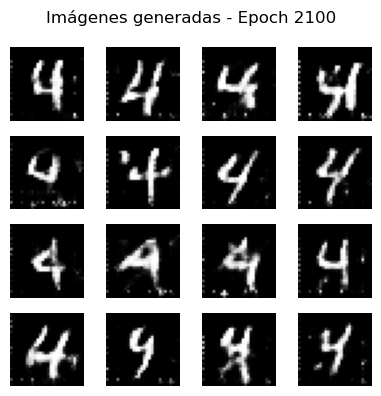

Epoch 2101
  D_real: 0.6873, D_fake: 0.6872, G: 1.0564
Epoch 2102
  D_real: 0.6872, D_fake: 0.6871, G: 1.0564
Epoch 2103
  D_real: 0.6871, D_fake: 0.6870, G: 1.0564
Epoch 2104
  D_real: 0.6870, D_fake: 0.6869, G: 1.0564
Epoch 2105
  D_real: 0.6869, D_fake: 0.6868, G: 1.0565
Epoch 2106
  D_real: 0.6868, D_fake: 0.6867, G: 1.0565
Epoch 2107
  D_real: 0.6867, D_fake: 0.6867, G: 1.0565
Epoch 2108
  D_real: 0.6867, D_fake: 0.6866, G: 1.0565
Epoch 2109
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2110
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2111
  D_real: 0.6866, D_fake: 0.6866, G: 1.0564
Epoch 2112
  D_real: 0.6866, D_fake: 0.6866, G: 1.0565
Epoch 2113
  D_real: 0.6865, D_fake: 0.6864, G: 1.0564
Epoch 2114
  D_real: 0.6865, D_fake: 0.6864, G: 1.0565
Epoch 2115
  D_real: 0.6864, D_fake: 0.6863, G: 1.0566
Epoch 2116
  D_real: 0.6864, D_fake: 0.6864, G: 1.0565
Epoch 2117
  D_real: 0.6864, D_fake: 0.6863, G: 1.0566
Epoch 2118
  D_real: 0.6863, D_fake: 0.6863, G: 1.0566
Epoch 2119

2025-04-23 17:43:53.473702: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


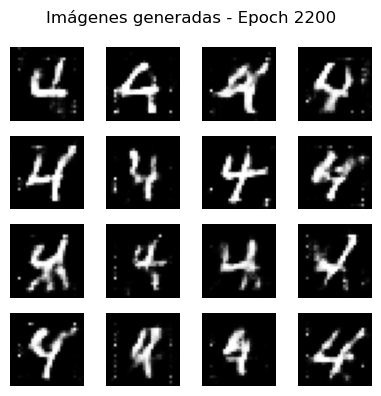

Epoch 2201
  D_real: 0.6836, D_fake: 0.6835, G: 1.0576
Epoch 2202
  D_real: 0.6835, D_fake: 0.6835, G: 1.0576
Epoch 2203
  D_real: 0.6836, D_fake: 0.6836, G: 1.0576
Epoch 2204
  D_real: 0.6836, D_fake: 0.6835, G: 1.0576
Epoch 2205
  D_real: 0.6835, D_fake: 0.6835, G: 1.0575
Epoch 2206
  D_real: 0.6835, D_fake: 0.6835, G: 1.0574
Epoch 2207
  D_real: 0.6835, D_fake: 0.6835, G: 1.0574
Epoch 2208
  D_real: 0.6836, D_fake: 0.6835, G: 1.0574
Epoch 2209
  D_real: 0.6836, D_fake: 0.6835, G: 1.0574
Epoch 2210
  D_real: 0.6835, D_fake: 0.6835, G: 1.0575
Epoch 2211
  D_real: 0.6835, D_fake: 0.6834, G: 1.0577
Epoch 2212
  D_real: 0.6833, D_fake: 0.6833, G: 1.0577
Epoch 2213
  D_real: 0.6833, D_fake: 0.6832, G: 1.0578
Epoch 2214
  D_real: 0.6832, D_fake: 0.6831, G: 1.0577
Epoch 2215
  D_real: 0.6831, D_fake: 0.6831, G: 1.0578
Epoch 2216
  D_real: 0.6831, D_fake: 0.6831, G: 1.0577
Epoch 2217
  D_real: 0.6831, D_fake: 0.6832, G: 1.0576
Epoch 2218
  D_real: 0.6832, D_fake: 0.6833, G: 1.0575
Epoch 2219

2025-04-23 17:44:06.210253: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


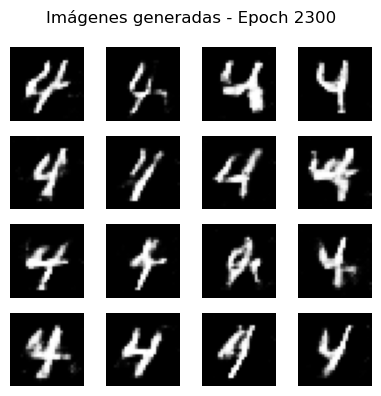

Epoch 2301
  D_real: 0.6814, D_fake: 0.6814, G: 1.0576
Epoch 2302
  D_real: 0.6814, D_fake: 0.6814, G: 1.0575
Epoch 2303
  D_real: 0.6814, D_fake: 0.6815, G: 1.0573
Epoch 2304
  D_real: 0.6815, D_fake: 0.6815, G: 1.0573
Epoch 2305
  D_real: 0.6816, D_fake: 0.6815, G: 1.0574
Epoch 2306
  D_real: 0.6815, D_fake: 0.6815, G: 1.0574
Epoch 2307
  D_real: 0.6815, D_fake: 0.6814, G: 1.0576
Epoch 2308
  D_real: 0.6814, D_fake: 0.6813, G: 1.0578
Epoch 2309
  D_real: 0.6813, D_fake: 0.6811, G: 1.0580
Epoch 2310
  D_real: 0.6811, D_fake: 0.6811, G: 1.0579
Epoch 2311
  D_real: 0.6811, D_fake: 0.6812, G: 1.0578
Epoch 2312
  D_real: 0.6811, D_fake: 0.6812, G: 1.0577
Epoch 2313
  D_real: 0.6812, D_fake: 0.6813, G: 1.0576
Epoch 2314
  D_real: 0.6813, D_fake: 0.6812, G: 1.0576
Epoch 2315
  D_real: 0.6813, D_fake: 0.6813, G: 1.0576
Epoch 2316
  D_real: 0.6814, D_fake: 0.6813, G: 1.0576
Epoch 2317
  D_real: 0.6813, D_fake: 0.6813, G: 1.0577
Epoch 2318
  D_real: 0.6813, D_fake: 0.6812, G: 1.0576
Epoch 2319

2025-04-23 17:44:19.167313: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


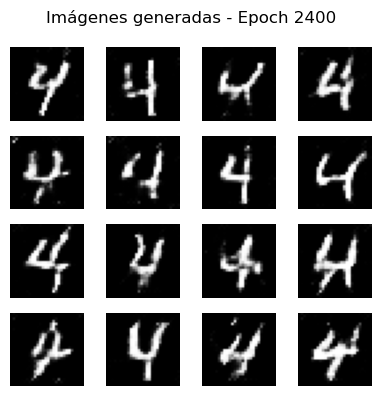

Epoch 2401
  D_real: 0.6780, D_fake: 0.6780, G: 1.0599
Epoch 2402
  D_real: 0.6779, D_fake: 0.6778, G: 1.0601
Epoch 2403
  D_real: 0.6778, D_fake: 0.6778, G: 1.0600
Epoch 2404
  D_real: 0.6778, D_fake: 0.6777, G: 1.0600
Epoch 2405
  D_real: 0.6777, D_fake: 0.6777, G: 1.0600
Epoch 2406
  D_real: 0.6777, D_fake: 0.6778, G: 1.0598
Epoch 2407
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2408
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2409
  D_real: 0.6778, D_fake: 0.6778, G: 1.0598
Epoch 2410
  D_real: 0.6778, D_fake: 0.6777, G: 1.0600
Epoch 2411
  D_real: 0.6777, D_fake: 0.6776, G: 1.0601
Epoch 2412
  D_real: 0.6776, D_fake: 0.6775, G: 1.0601
Epoch 2413
  D_real: 0.6775, D_fake: 0.6774, G: 1.0602
Epoch 2414
  D_real: 0.6774, D_fake: 0.6775, G: 1.0601
Epoch 2415
  D_real: 0.6775, D_fake: 0.6775, G: 1.0600
Epoch 2416
  D_real: 0.6775, D_fake: 0.6775, G: 1.0600
Epoch 2417
  D_real: 0.6775, D_fake: 0.6774, G: 1.0601
Epoch 2418
  D_real: 0.6773, D_fake: 0.6773, G: 1.0602
Epoch 2419

2025-04-23 17:44:31.965274: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


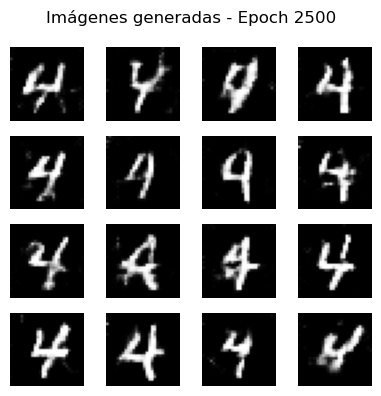

Epoch 2501
  D_real: 0.6741, D_fake: 0.6741, G: 1.0622
Epoch 2502
  D_real: 0.6741, D_fake: 0.6740, G: 1.0623
Epoch 2503
  D_real: 0.6740, D_fake: 0.6740, G: 1.0623
Epoch 2504
  D_real: 0.6740, D_fake: 0.6739, G: 1.0623
Epoch 2505
  D_real: 0.6740, D_fake: 0.6739, G: 1.0623
Epoch 2506
  D_real: 0.6739, D_fake: 0.6738, G: 1.0624
Epoch 2507
  D_real: 0.6738, D_fake: 0.6737, G: 1.0625
Epoch 2508
  D_real: 0.6738, D_fake: 0.6737, G: 1.0626
Epoch 2509
  D_real: 0.6737, D_fake: 0.6736, G: 1.0627
Epoch 2510
  D_real: 0.6736, D_fake: 0.6735, G: 1.0627
Epoch 2511
  D_real: 0.6735, D_fake: 0.6736, G: 1.0625
Epoch 2512
  D_real: 0.6736, D_fake: 0.6736, G: 1.0625
Epoch 2513
  D_real: 0.6736, D_fake: 0.6736, G: 1.0624
Epoch 2514
  D_real: 0.6736, D_fake: 0.6736, G: 1.0623
Epoch 2515
  D_real: 0.6736, D_fake: 0.6736, G: 1.0624
Epoch 2516
  D_real: 0.6737, D_fake: 0.6737, G: 1.0623
Epoch 2517
  D_real: 0.6738, D_fake: 0.6738, G: 1.0622
Epoch 2518
  D_real: 0.6738, D_fake: 0.6737, G: 1.0622
Epoch 2519

2025-04-23 17:44:45.258430: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


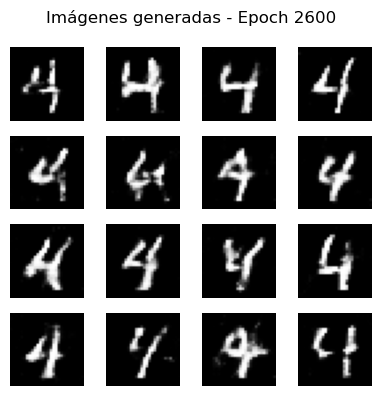

Epoch 2601
  D_real: 0.6720, D_fake: 0.6719, G: 1.0627
Epoch 2602
  D_real: 0.6719, D_fake: 0.6719, G: 1.0626
Epoch 2603
  D_real: 0.6719, D_fake: 0.6719, G: 1.0626
Epoch 2604
  D_real: 0.6719, D_fake: 0.6718, G: 1.0626
Epoch 2605
  D_real: 0.6718, D_fake: 0.6718, G: 1.0627
Epoch 2606
  D_real: 0.6717, D_fake: 0.6718, G: 1.0626
Epoch 2607
  D_real: 0.6717, D_fake: 0.6717, G: 1.0626
Epoch 2608
  D_real: 0.6717, D_fake: 0.6718, G: 1.0625
Epoch 2609
  D_real: 0.6718, D_fake: 0.6719, G: 1.0624
Epoch 2610
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2611
  D_real: 0.6721, D_fake: 0.6720, G: 1.0624
Epoch 2612
  D_real: 0.6721, D_fake: 0.6721, G: 1.0624
Epoch 2613
  D_real: 0.6721, D_fake: 0.6720, G: 1.0625
Epoch 2614
  D_real: 0.6720, D_fake: 0.6720, G: 1.0624
Epoch 2615
  D_real: 0.6720, D_fake: 0.6720, G: 1.0624
Epoch 2616
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2617
  D_real: 0.6720, D_fake: 0.6720, G: 1.0623
Epoch 2618
  D_real: 0.6720, D_fake: 0.6719, G: 1.0623
Epoch 2619

2025-04-23 17:44:58.386210: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


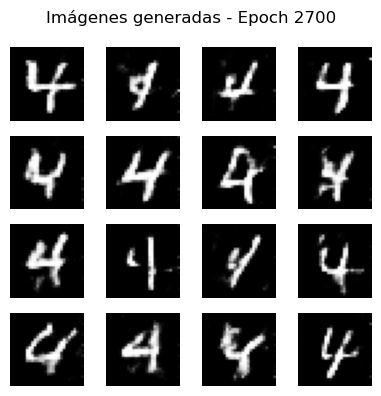

Epoch 2701
  D_real: 0.6697, D_fake: 0.6696, G: 1.0639
Epoch 2702
  D_real: 0.6696, D_fake: 0.6696, G: 1.0638
Epoch 2703
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2704
  D_real: 0.6697, D_fake: 0.6696, G: 1.0638
Epoch 2705
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2706
  D_real: 0.6696, D_fake: 0.6696, G: 1.0637
Epoch 2707
  D_real: 0.6696, D_fake: 0.6695, G: 1.0640
Epoch 2708
  D_real: 0.6695, D_fake: 0.6694, G: 1.0641
Epoch 2709
  D_real: 0.6694, D_fake: 0.6693, G: 1.0643
Epoch 2710
  D_real: 0.6693, D_fake: 0.6693, G: 1.0642
Epoch 2711
  D_real: 0.6693, D_fake: 0.6692, G: 1.0643
Epoch 2712
  D_real: 0.6692, D_fake: 0.6692, G: 1.0643
Epoch 2713
  D_real: 0.6692, D_fake: 0.6692, G: 1.0642
Epoch 2714
  D_real: 0.6692, D_fake: 0.6692, G: 1.0641
Epoch 2715
  D_real: 0.6692, D_fake: 0.6692, G: 1.0641
Epoch 2716
  D_real: 0.6692, D_fake: 0.6692, G: 1.0640
Epoch 2717
  D_real: 0.6693, D_fake: 0.6693, G: 1.0639
Epoch 2718
  D_real: 0.6693, D_fake: 0.6694, G: 1.0639
Epoch 2719

2025-04-23 17:45:11.129154: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


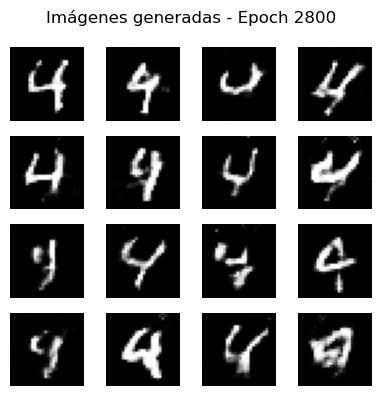

Epoch 2801
  D_real: 0.6674, D_fake: 0.6673, G: 1.0655
Epoch 2802
  D_real: 0.6673, D_fake: 0.6672, G: 1.0657
Epoch 2803
  D_real: 0.6672, D_fake: 0.6671, G: 1.0658
Epoch 2804
  D_real: 0.6671, D_fake: 0.6671, G: 1.0657
Epoch 2805
  D_real: 0.6672, D_fake: 0.6673, G: 1.0657
Epoch 2806
  D_real: 0.6672, D_fake: 0.6673, G: 1.0655
Epoch 2807
  D_real: 0.6674, D_fake: 0.6674, G: 1.0654
Epoch 2808
  D_real: 0.6675, D_fake: 0.6675, G: 1.0654
Epoch 2809
  D_real: 0.6675, D_fake: 0.6674, G: 1.0655
Epoch 2810
  D_real: 0.6675, D_fake: 0.6674, G: 1.0657
Epoch 2811
  D_real: 0.6675, D_fake: 0.6674, G: 1.0659
Epoch 2812
  D_real: 0.6674, D_fake: 0.6673, G: 1.0661
Epoch 2813
  D_real: 0.6673, D_fake: 0.6672, G: 1.0662
Epoch 2814
  D_real: 0.6672, D_fake: 0.6671, G: 1.0663
Epoch 2815
  D_real: 0.6671, D_fake: 0.6670, G: 1.0664
Epoch 2816
  D_real: 0.6669, D_fake: 0.6669, G: 1.0664
Epoch 2817
  D_real: 0.6669, D_fake: 0.6669, G: 1.0663
Epoch 2818
  D_real: 0.6669, D_fake: 0.6669, G: 1.0662
Epoch 2819

2025-04-23 17:45:23.889211: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


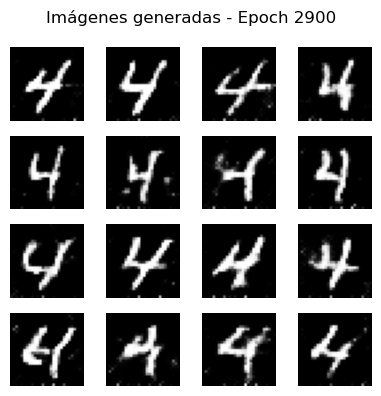

Epoch 2901
  D_real: 0.6636, D_fake: 0.6636, G: 1.0690
Epoch 2902
  D_real: 0.6636, D_fake: 0.6635, G: 1.0691
Epoch 2903
  D_real: 0.6635, D_fake: 0.6635, G: 1.0691
Epoch 2904
  D_real: 0.6635, D_fake: 0.6634, G: 1.0691
Epoch 2905
  D_real: 0.6634, D_fake: 0.6634, G: 1.0691
Epoch 2906
  D_real: 0.6634, D_fake: 0.6634, G: 1.0691
Epoch 2907
  D_real: 0.6633, D_fake: 0.6633, G: 1.0692
Epoch 2908
  D_real: 0.6632, D_fake: 0.6632, G: 1.0691
Epoch 2909
  D_real: 0.6633, D_fake: 0.6633, G: 1.0691
Epoch 2910
  D_real: 0.6633, D_fake: 0.6632, G: 1.0692
Epoch 2911
  D_real: 0.6632, D_fake: 0.6632, G: 1.0692
Epoch 2912
  D_real: 0.6631, D_fake: 0.6632, G: 1.0692
Epoch 2913
  D_real: 0.6632, D_fake: 0.6631, G: 1.0693
Epoch 2914
  D_real: 0.6632, D_fake: 0.6631, G: 1.0694
Epoch 2915
  D_real: 0.6631, D_fake: 0.6631, G: 1.0694
Epoch 2916
  D_real: 0.6631, D_fake: 0.6631, G: 1.0693
Epoch 2917
  D_real: 0.6631, D_fake: 0.6630, G: 1.0694
Epoch 2918
  D_real: 0.6630, D_fake: 0.6630, G: 1.0693
Epoch 2919

2025-04-23 17:45:36.809568: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


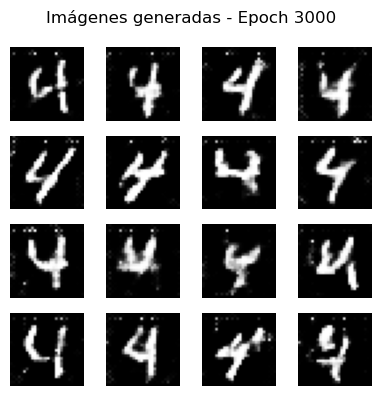

In [38]:
# Entrenamos 3000 epocs
entrenar_gan(3000)

In [ ]:
"""
# Función para evaluar la calidad visual usando SSIM
def evaluar_calidad_visual(imagenes_generadas, imagenes_reales):
    calidad_total = 0
    for img_gen, img_real in zip(imagenes_generadas, imagenes_reales):
        img_gen = (img_gen + 1) / 2  # Desnormalizar a rango [0, 1]
        img_real = (img_real + 1) / 2  # Desnormalizar a rango [0, 1]
        calidad_total += ssim(img_gen.squeeze(), img_real.squeeze(), data_range=1.0)
    return calidad_total / len(imagenes_generadas)
"""

# Significado de cada métrica
## 1. D_real (Discriminador real)
Este valor mide cuán bien el discriminador puede distinguir entre las **imágenes reales** (las que provienen del conjunto de entrenamiento) y las **falsas** (las generadas por el generador).

- **D_real alto**: El discriminador está haciendo bien su trabajo, ya que está clasificando correctamente las imágenes reales como reales. Esto indica que el discriminador **no está siendo engañado fácilmente** por imágenes reales.
  
- **D_real bajo**: El discriminador tiene dificultades para distinguir las imágenes reales, es decir, está **fallando en su tarea**. Este comportamiento es inusual en un entrenamiento bien equilibrado, ya que implica que el discriminador no está aprendiendo correctamente.

## 2. D_fake (Discriminador falso)
Este valor mide cuán bien el discriminador puede identificar las **imágenes generadas** (las falsas) como tales.

- **D_fake alto**: El discriminador es capaz de identificar correctamente las imágenes generadas como falsas. Esto significa que el discriminador **está funcionando bien**, ya que está identificando las imágenes falsas del generador correctamente.

- **D_fake bajo**: Si este valor es bajo, el discriminador está siendo **engañado por el generador**, porque está clasificando las imágenes generadas como reales. Esto es bueno para el generador porque significa que está mejorando y generando imágenes más realistas.

## 3. G (Generador)
El valor **G** mide la calidad general del **generador**. Cuanto más alto sea, mejor será la capacidad del generador para crear imágenes realistas que engañen al discriminador.

- **G alto**: Un valor alto de G indica que el generador está haciendo un **muy buen trabajo** creando imágenes que son casi indistinguibles de las reales. Esto es lo que queremos en un GAN, ya que su objetivo es generar imágenes que engañen al discriminador.

- **G bajo**: Un valor bajo de G significa que el generador está **fallando** en producir imágenes de calidad, que son fácilmente detectadas como falsas por el discriminador.

# Riesgo del modo colapso de un modelo GAN
Se produce cuando un GAN empieza a producir siempo lo mismo o muy poca variedad de imágenes, aunque las entradas de ruido sean diferentes.

Se produce porque el genador descubre una trampa en el entrenamiento:

* Encuentra una imagen (o patrón) que el discriminador acepta como "real", empieza a repetir esa misma imagen porque funciona.

* El discriminador no es lo bastante fuerte para decir: "oye, esto ya lo vi".

* El modelo colapsa en un solo modo de salida.

# ¿Cómo seleccionar la mejor época?
La mejor época puede depender de varios factores, pero en general se busca:

* Discriminador balanceado -> D_real y D_fake cerca de 0.5
* Buen generador -> G alto (entre 1 y 2, o más si es estable)
* Discriminador no dominante -> D_fake no demasiado bajo
* Generador aprendiendo bien -> G subiendo, imágenes de buena calidad



Analizando los resultados época a época, vemos que la época 407 presenta unos buenos resultados. Vamos guardar el modelo en entrenado hasta esa época y ver las imágenes que genera
  D_real: 0.5676, D_fake: 0.5669, G: 1.4465

In [39]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

def entrenar_gan_guardar(N_ITS, ruta_generador_guardado):
    x_train = cargar_datos()
    generador = crear_generador()
    discriminador = crear_discriminador()
    gan = crear_GAN(generador, discriminador)

    TAM_LOTE = 64

    for i in range(1, N_ITS + 1):
        print(f"Epoch {i}")

        ruido = np.random.normal(0, 1, (TAM_LOTE, TAM_ENTRADA))
        imagenes_falsas = generador.predict(ruido, verbose=0)
        idx = np.random.randint(0, x_train.shape[0], TAM_LOTE)
        imagenes_reales = x_train[idx]

        reales = np.ones(TAM_LOTE) * 0.9
        falsas = np.zeros(TAM_LOTE)

        discriminador.trainable = True
        d_loss_real = discriminador.train_on_batch(imagenes_reales, reales)
        d_loss_fake = discriminador.train_on_batch(imagenes_falsas, falsas)

        discriminador.trainable = False
        g_loss = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

        print(f"  D_real: {d_loss_real:.4f}, D_fake: {d_loss_fake:.4f}, G: {g_loss:.4f}")

        if i == 1 or i % 100 == 0:
            graficar_imagenes_generadas(i, generador)

    # Guardar el generador entrenado en un archivo
    generador.save(ruta_generador_guardado)
    print(f"Modelo generador guardado en {ruta_generador_guardado}")


In [40]:
# VOlvemos a establecer los valores de los optimizadores
opt_d = Adam(learning_rate=0.0001, beta_1=0.5)
opt_gan = Adam(learning_rate=0.0002, beta_1=0.5)


Cargando dígitos "4" desde MNIST...¡Listo!
Epoch 1
  D_real: 0.6002, D_fake: 0.6583, G: 0.6282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


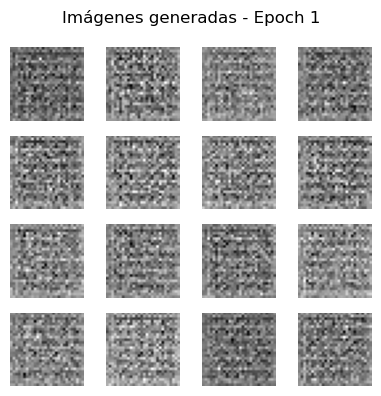

Epoch 2
  D_real: 0.5819, D_fake: 0.6900, G: 0.5042
Epoch 3
  D_real: 0.6288, D_fake: 0.7131, G: 0.4626
Epoch 4
  D_real: 0.6656, D_fake: 0.7285, G: 0.4604
Epoch 5
  D_real: 0.6918, D_fake: 0.7084, G: 0.5254
Epoch 6
  D_real: 0.6849, D_fake: 0.6904, G: 0.5912
Epoch 7
  D_real: 0.6675, D_fake: 0.6585, G: 0.6659
Epoch 8
  D_real: 0.6419, D_fake: 0.6307, G: 0.7327
Epoch 9
  D_real: 0.6197, D_fake: 0.6050, G: 0.7983
Epoch 10
  D_real: 0.5937, D_fake: 0.5796, G: 0.8693
Epoch 11
  D_real: 0.5695, D_fake: 0.5575, G: 0.9260
Epoch 12
  D_real: 0.5500, D_fake: 0.5392, G: 0.9713
Epoch 13
  D_real: 0.5344, D_fake: 0.5270, G: 1.0215
Epoch 14
  D_real: 0.5213, D_fake: 0.5136, G: 1.0603
Epoch 15
  D_real: 0.5091, D_fake: 0.5041, G: 1.0905
Epoch 16
  D_real: 0.5009, D_fake: 0.4939, G: 1.1272
Epoch 17
  D_real: 0.4912, D_fake: 0.4832, G: 1.1540
Epoch 18
  D_real: 0.4817, D_fake: 0.4772, G: 1.1829
Epoch 19
  D_real: 0.4757, D_fake: 0.4728, G: 1.2053
Epoch 20
  D_real: 0.4715, D_fake: 0.4668, G: 1.2312
E

2025-04-23 17:45:51.484302: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


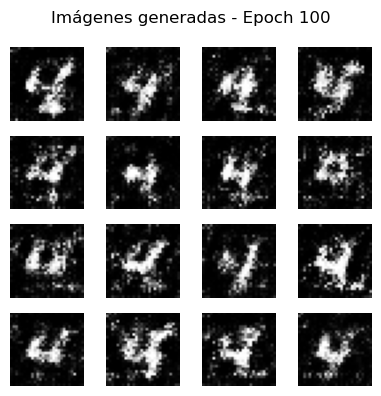

Epoch 101
  D_real: 0.5228, D_fake: 0.5230, G: 1.6208
Epoch 102
  D_real: 0.5248, D_fake: 0.5257, G: 1.6180
Epoch 103
  D_real: 0.5275, D_fake: 0.5279, G: 1.6156
Epoch 104
  D_real: 0.5294, D_fake: 0.5292, G: 1.6124
Epoch 105
  D_real: 0.5307, D_fake: 0.5303, G: 1.6081
Epoch 106
  D_real: 0.5318, D_fake: 0.5319, G: 1.6046
Epoch 107
  D_real: 0.5335, D_fake: 0.5348, G: 1.5997
Epoch 108
  D_real: 0.5363, D_fake: 0.5367, G: 1.5965
Epoch 109
  D_real: 0.5380, D_fake: 0.5374, G: 1.5949
Epoch 110
  D_real: 0.5383, D_fake: 0.5373, G: 1.5948
Epoch 111
  D_real: 0.5395, D_fake: 0.5385, G: 1.5920
Epoch 112
  D_real: 0.5388, D_fake: 0.5393, G: 1.5864
Epoch 113
  D_real: 0.5397, D_fake: 0.5408, G: 1.5833
Epoch 114
  D_real: 0.5420, D_fake: 0.5427, G: 1.5800
Epoch 115
  D_real: 0.5441, D_fake: 0.5440, G: 1.5774
Epoch 116
  D_real: 0.5460, D_fake: 0.5463, G: 1.5751
Epoch 117
  D_real: 0.5473, D_fake: 0.5473, G: 1.5726
Epoch 118
  D_real: 0.5489, D_fake: 0.5485, G: 1.5694
Epoch 119
  D_real: 0.5494, 

2025-04-23 17:46:04.383833: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


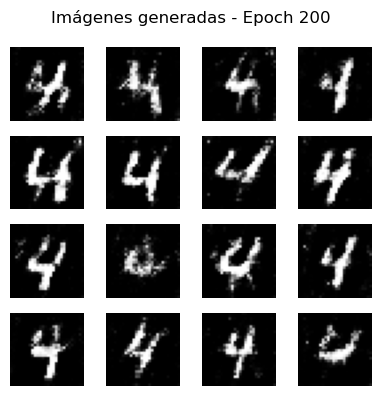

Epoch 201
  D_real: 0.6269, D_fake: 0.6270, G: 1.3864
Epoch 202
  D_real: 0.6278, D_fake: 0.6280, G: 1.3848
Epoch 203
  D_real: 0.6285, D_fake: 0.6283, G: 1.3838
Epoch 204
  D_real: 0.6288, D_fake: 0.6288, G: 1.3813
Epoch 205
  D_real: 0.6296, D_fake: 0.6299, G: 1.3798
Epoch 206
  D_real: 0.6302, D_fake: 0.6303, G: 1.3785
Epoch 207
  D_real: 0.6310, D_fake: 0.6313, G: 1.3765
Epoch 208
  D_real: 0.6318, D_fake: 0.6321, G: 1.3741
Epoch 209
  D_real: 0.6327, D_fake: 0.6327, G: 1.3723
Epoch 210
  D_real: 0.6334, D_fake: 0.6334, G: 1.3709
Epoch 211
  D_real: 0.6338, D_fake: 0.6338, G: 1.3702
Epoch 212
  D_real: 0.6344, D_fake: 0.6339, G: 1.3698
Epoch 213
  D_real: 0.6347, D_fake: 0.6344, G: 1.3684
Epoch 214
  D_real: 0.6349, D_fake: 0.6351, G: 1.3671
Epoch 215
  D_real: 0.6356, D_fake: 0.6356, G: 1.3657
Epoch 216
  D_real: 0.6363, D_fake: 0.6367, G: 1.3642
Epoch 217
  D_real: 0.6374, D_fake: 0.6376, G: 1.3621
Epoch 218
  D_real: 0.6383, D_fake: 0.6382, G: 1.3604
Epoch 219
  D_real: 0.6389, 

2025-04-23 17:46:17.102983: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


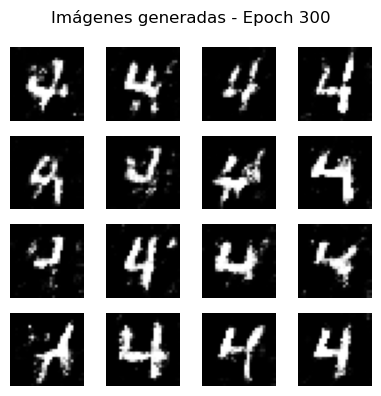

Epoch 301
  D_real: 0.6760, D_fake: 0.6760, G: 1.2648
Epoch 302
  D_real: 0.6765, D_fake: 0.6766, G: 1.2640
Epoch 303
  D_real: 0.6768, D_fake: 0.6771, G: 1.2628
Epoch 304
  D_real: 0.6775, D_fake: 0.6776, G: 1.2617
Epoch 305
  D_real: 0.6781, D_fake: 0.6781, G: 1.2607
Epoch 306
  D_real: 0.6785, D_fake: 0.6784, G: 1.2602
Epoch 307
  D_real: 0.6787, D_fake: 0.6788, G: 1.2593
Epoch 308
  D_real: 0.6792, D_fake: 0.6790, G: 1.2585
Epoch 309
  D_real: 0.6793, D_fake: 0.6794, G: 1.2576
Epoch 310
  D_real: 0.6796, D_fake: 0.6796, G: 1.2567
Epoch 311
  D_real: 0.6800, D_fake: 0.6800, G: 1.2556
Epoch 312
  D_real: 0.6803, D_fake: 0.6804, G: 1.2551
Epoch 313
  D_real: 0.6806, D_fake: 0.6805, G: 1.2543
Epoch 314
  D_real: 0.6809, D_fake: 0.6810, G: 1.2534
Epoch 315
  D_real: 0.6812, D_fake: 0.6813, G: 1.2529
Epoch 316
  D_real: 0.6814, D_fake: 0.6814, G: 1.2525
Epoch 317
  D_real: 0.6819, D_fake: 0.6818, G: 1.2524
Epoch 318
  D_real: 0.6823, D_fake: 0.6824, G: 1.2512
Epoch 319
  D_real: 0.6827, 

2025-04-23 17:46:29.836115: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


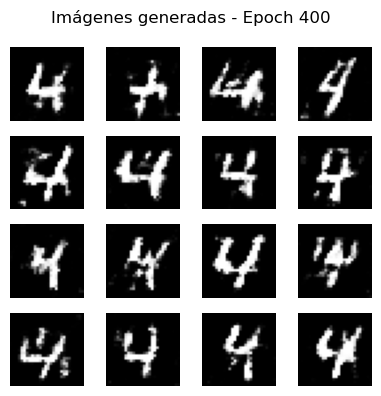

Epoch 401
  D_real: 0.7037, D_fake: 0.7038, G: 1.1947
Epoch 402
  D_real: 0.7040, D_fake: 0.7040, G: 1.1941
Epoch 403
  D_real: 0.7043, D_fake: 0.7042, G: 1.1938
Epoch 404
  D_real: 0.7045, D_fake: 0.7042, G: 1.1934
Epoch 405
  D_real: 0.7045, D_fake: 0.7045, G: 1.1927
Epoch 406
  D_real: 0.7047, D_fake: 0.7045, G: 1.1921
Epoch 407
  D_real: 0.7046, D_fake: 0.7047, G: 1.1914
Epoch 408
  D_real: 0.7048, D_fake: 0.7048, G: 1.1908
Epoch 409
  D_real: 0.7050, D_fake: 0.7049, G: 1.1901
Epoch 410
  D_real: 0.7052, D_fake: 0.7051, G: 1.1896
Epoch 411
  D_real: 0.7052, D_fake: 0.7052, G: 1.1887
Epoch 412
  D_real: 0.7054, D_fake: 0.7052, G: 1.1883
Epoch 413
  D_real: 0.7054, D_fake: 0.7054, G: 1.1879
Epoch 414
  D_real: 0.7057, D_fake: 0.7058, G: 1.1872
Epoch 415
  D_real: 0.7060, D_fake: 0.7061, G: 1.1866
Epoch 416
  D_real: 0.7061, D_fake: 0.7063, G: 1.1860
Epoch 417
  D_real: 0.7067, D_fake: 0.7066, G: 1.1855
Epoch 418
  D_real: 0.7068, D_fake: 0.7068, G: 1.1849
Epoch 419
  D_real: 0.7071, 

2025-04-23 17:46:42.689226: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


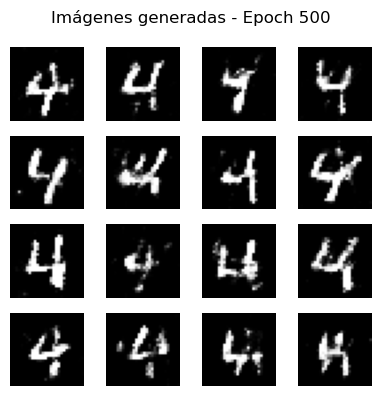

Epoch 501
  D_real: 0.7135, D_fake: 0.7134, G: 1.1553
Epoch 502
  D_real: 0.7134, D_fake: 0.7132, G: 1.1550
Epoch 503
  D_real: 0.7134, D_fake: 0.7133, G: 1.1545
Epoch 504
  D_real: 0.7133, D_fake: 0.7132, G: 1.1541
Epoch 505
  D_real: 0.7133, D_fake: 0.7133, G: 1.1537
Epoch 506
  D_real: 0.7133, D_fake: 0.7133, G: 1.1533
Epoch 507
  D_real: 0.7135, D_fake: 0.7134, G: 1.1531
Epoch 508
  D_real: 0.7135, D_fake: 0.7135, G: 1.1527
Epoch 509
  D_real: 0.7136, D_fake: 0.7137, G: 1.1524
Epoch 510
  D_real: 0.7139, D_fake: 0.7140, G: 1.1520
Epoch 511
  D_real: 0.7141, D_fake: 0.7140, G: 1.1517
Epoch 512
  D_real: 0.7142, D_fake: 0.7140, G: 1.1518
Epoch 513
  D_real: 0.7141, D_fake: 0.7139, G: 1.1516
Epoch 514
  D_real: 0.7139, D_fake: 0.7138, G: 1.1515
Epoch 515
  D_real: 0.7140, D_fake: 0.7138, G: 1.1513
Epoch 516
  D_real: 0.7138, D_fake: 0.7138, G: 1.1509
Epoch 517
  D_real: 0.7139, D_fake: 0.7138, G: 1.1509
Epoch 518
  D_real: 0.7140, D_fake: 0.7140, G: 1.1503
Epoch 519
  D_real: 0.7140, 

2025-04-23 17:46:55.510017: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


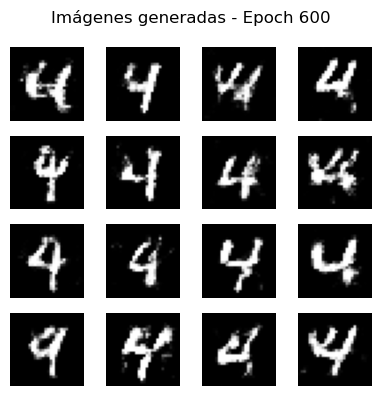

Epoch 601
  D_real: 0.7178, D_fake: 0.7178, G: 1.1260
Epoch 602
  D_real: 0.7178, D_fake: 0.7178, G: 1.1258
Epoch 603
  D_real: 0.7179, D_fake: 0.7178, G: 1.1256
Epoch 604
  D_real: 0.7179, D_fake: 0.7178, G: 1.1257
Epoch 605
  D_real: 0.7178, D_fake: 0.7177, G: 1.1255
Epoch 606
  D_real: 0.7178, D_fake: 0.7177, G: 1.1253
Epoch 607
  D_real: 0.7178, D_fake: 0.7177, G: 1.1251
Epoch 608
  D_real: 0.7178, D_fake: 0.7178, G: 1.1247
Epoch 609
  D_real: 0.7178, D_fake: 0.7177, G: 1.1244
Epoch 610
  D_real: 0.7179, D_fake: 0.7178, G: 1.1243
Epoch 611
  D_real: 0.7178, D_fake: 0.7178, G: 1.1240
Epoch 612
  D_real: 0.7179, D_fake: 0.7180, G: 1.1238
Epoch 613
  D_real: 0.7181, D_fake: 0.7180, G: 1.1235
Epoch 614
  D_real: 0.7181, D_fake: 0.7179, G: 1.1234
Epoch 615
  D_real: 0.7179, D_fake: 0.7178, G: 1.1232
Epoch 616
  D_real: 0.7178, D_fake: 0.7177, G: 1.1230
Epoch 617
  D_real: 0.7178, D_fake: 0.7177, G: 1.1229
Epoch 618
  D_real: 0.7177, D_fake: 0.7177, G: 1.1227
Epoch 619
  D_real: 0.7179, 

2025-04-23 17:47:08.052862: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


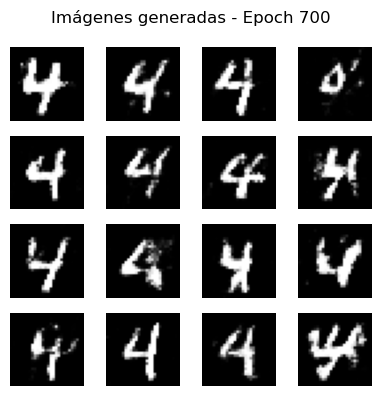

Epoch 701
  D_real: 0.7191, D_fake: 0.7190, G: 1.1072
Epoch 702
  D_real: 0.7191, D_fake: 0.7190, G: 1.1070
Epoch 703
  D_real: 0.7191, D_fake: 0.7191, G: 1.1069
Epoch 704
  D_real: 0.7192, D_fake: 0.7191, G: 1.1067
Epoch 705
  D_real: 0.7192, D_fake: 0.7192, G: 1.1065
Epoch 706
  D_real: 0.7192, D_fake: 0.7191, G: 1.1063
Epoch 707
  D_real: 0.7193, D_fake: 0.7192, G: 1.1063
Epoch 708
  D_real: 0.7194, D_fake: 0.7193, G: 1.1061
Epoch 709
  D_real: 0.7194, D_fake: 0.7193, G: 1.1061
Epoch 710
  D_real: 0.7194, D_fake: 0.7192, G: 1.1061
Epoch 711
  D_real: 0.7193, D_fake: 0.7192, G: 1.1059
Epoch 712
  D_real: 0.7193, D_fake: 0.7192, G: 1.1059
Epoch 713
  D_real: 0.7193, D_fake: 0.7191, G: 1.1059
Epoch 714
  D_real: 0.7192, D_fake: 0.7192, G: 1.1056
Epoch 715
  D_real: 0.7192, D_fake: 0.7191, G: 1.1054
Epoch 716
  D_real: 0.7191, D_fake: 0.7190, G: 1.1054
Epoch 717
  D_real: 0.7191, D_fake: 0.7190, G: 1.1053
Epoch 718
  D_real: 0.7191, D_fake: 0.7190, G: 1.1053
Epoch 719
  D_real: 0.7190, 

2025-04-23 17:47:20.950634: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


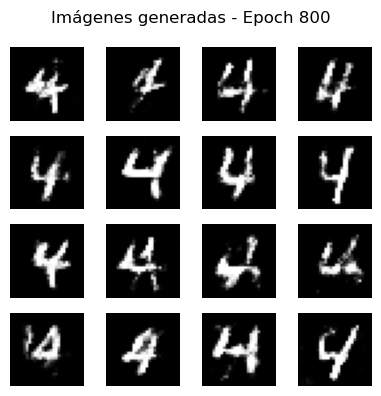

Epoch 801
  D_real: 0.7185, D_fake: 0.7184, G: 1.0945
Epoch 802
  D_real: 0.7184, D_fake: 0.7183, G: 1.0945
Epoch 803
  D_real: 0.7184, D_fake: 0.7183, G: 1.0944
Epoch 804
  D_real: 0.7183, D_fake: 0.7183, G: 1.0943
Epoch 805
  D_real: 0.7183, D_fake: 0.7183, G: 1.0942
Epoch 806
  D_real: 0.7183, D_fake: 0.7183, G: 1.0940
Epoch 807
  D_real: 0.7184, D_fake: 0.7184, G: 1.0939
Epoch 808
  D_real: 0.7185, D_fake: 0.7184, G: 1.0936
Epoch 809
  D_real: 0.7185, D_fake: 0.7185, G: 1.0935
Epoch 810
  D_real: 0.7186, D_fake: 0.7187, G: 1.0931
Epoch 811
  D_real: 0.7187, D_fake: 0.7187, G: 1.0930
Epoch 812
  D_real: 0.7188, D_fake: 0.7187, G: 1.0930
Epoch 813
  D_real: 0.7188, D_fake: 0.7187, G: 1.0930
Epoch 814
  D_real: 0.7188, D_fake: 0.7186, G: 1.0931
Epoch 815
  D_real: 0.7187, D_fake: 0.7185, G: 1.0932
Epoch 816
  D_real: 0.7186, D_fake: 0.7185, G: 1.0930
Epoch 817
  D_real: 0.7184, D_fake: 0.7184, G: 1.0929
Epoch 818
  D_real: 0.7184, D_fake: 0.7184, G: 1.0927
Epoch 819
  D_real: 0.7184, 

2025-04-23 17:47:33.624235: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


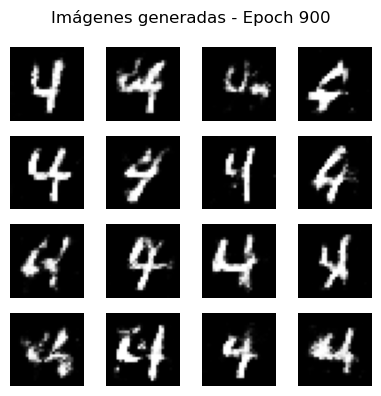

Epoch 901
  D_real: 0.7173, D_fake: 0.7172, G: 1.0839
Epoch 902
  D_real: 0.7172, D_fake: 0.7171, G: 1.0839
Epoch 903
  D_real: 0.7173, D_fake: 0.7172, G: 1.0838
Epoch 904
  D_real: 0.7172, D_fake: 0.7172, G: 1.0836
Epoch 905
  D_real: 0.7172, D_fake: 0.7173, G: 1.0832
Epoch 906
  D_real: 0.7174, D_fake: 0.7175, G: 1.0828
Epoch 907
  D_real: 0.7175, D_fake: 0.7176, G: 1.0825
Epoch 908
  D_real: 0.7177, D_fake: 0.7177, G: 1.0822
Epoch 909
  D_real: 0.7179, D_fake: 0.7178, G: 1.0821
Epoch 910
  D_real: 0.7179, D_fake: 0.7178, G: 1.0821
Epoch 911
  D_real: 0.7179, D_fake: 0.7178, G: 1.0820
Epoch 912
  D_real: 0.7179, D_fake: 0.7178, G: 1.0819
Epoch 913
  D_real: 0.7179, D_fake: 0.7178, G: 1.0819
Epoch 914
  D_real: 0.7178, D_fake: 0.7176, G: 1.0820
Epoch 915
  D_real: 0.7177, D_fake: 0.7175, G: 1.0820
Epoch 916
  D_real: 0.7175, D_fake: 0.7175, G: 1.0820
Epoch 917
  D_real: 0.7174, D_fake: 0.7175, G: 1.0817
Epoch 918
  D_real: 0.7175, D_fake: 0.7175, G: 1.0815
Epoch 919
  D_real: 0.7176, 

2025-04-23 17:47:46.434430: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


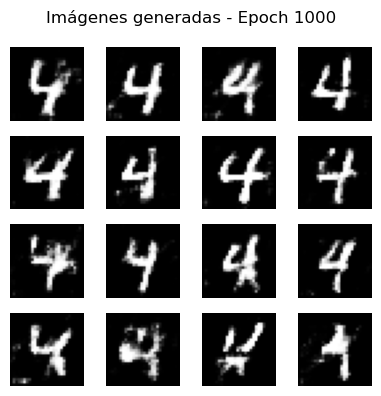

Epoch 1001
  D_real: 0.7153, D_fake: 0.7154, G: 1.0761
Epoch 1002
  D_real: 0.7154, D_fake: 0.7153, G: 1.0762
Epoch 1003
  D_real: 0.7154, D_fake: 0.7153, G: 1.0762
Epoch 1004
  D_real: 0.7153, D_fake: 0.7152, G: 1.0763
Epoch 1005
  D_real: 0.7152, D_fake: 0.7151, G: 1.0763
Epoch 1006
  D_real: 0.7151, D_fake: 0.7151, G: 1.0761
Epoch 1007
  D_real: 0.7151, D_fake: 0.7150, G: 1.0760
Epoch 1008
  D_real: 0.7151, D_fake: 0.7149, G: 1.0761
Epoch 1009
  D_real: 0.7150, D_fake: 0.7150, G: 1.0760
Epoch 1010
  D_real: 0.7150, D_fake: 0.7150, G: 1.0759
Epoch 1011
  D_real: 0.7150, D_fake: 0.7150, G: 1.0757
Epoch 1012
  D_real: 0.7150, D_fake: 0.7150, G: 1.0756
Epoch 1013
  D_real: 0.7150, D_fake: 0.7150, G: 1.0755
Epoch 1014
  D_real: 0.7151, D_fake: 0.7150, G: 1.0757
Epoch 1015
  D_real: 0.7150, D_fake: 0.7150, G: 1.0756
Epoch 1016
  D_real: 0.7150, D_fake: 0.7149, G: 1.0755
Epoch 1017
  D_real: 0.7150, D_fake: 0.7150, G: 1.0753
Epoch 1018
  D_real: 0.7151, D_fake: 0.7151, G: 1.0751
Epoch 1019

2025-04-23 17:47:59.515039: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


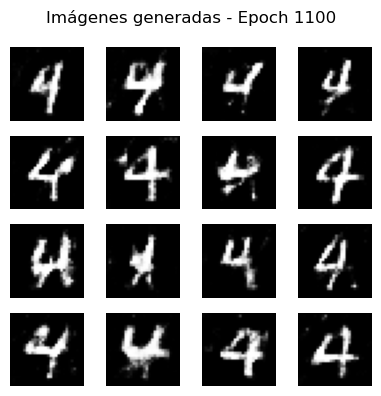

Epoch 1101
  D_real: 0.7138, D_fake: 0.7138, G: 1.0696
Epoch 1102
  D_real: 0.7139, D_fake: 0.7138, G: 1.0694
Epoch 1103
  D_real: 0.7138, D_fake: 0.7138, G: 1.0693
Epoch 1104
  D_real: 0.7139, D_fake: 0.7137, G: 1.0694
Epoch 1105
  D_real: 0.7137, D_fake: 0.7135, G: 1.0696
Epoch 1106
  D_real: 0.7136, D_fake: 0.7134, G: 1.0698
Epoch 1107
  D_real: 0.7134, D_fake: 0.7132, G: 1.0701
Epoch 1108
  D_real: 0.7131, D_fake: 0.7130, G: 1.0701
Epoch 1109
  D_real: 0.7130, D_fake: 0.7130, G: 1.0700
Epoch 1110
  D_real: 0.7129, D_fake: 0.7130, G: 1.0698
Epoch 1111
  D_real: 0.7130, D_fake: 0.7130, G: 1.0696
Epoch 1112
  D_real: 0.7130, D_fake: 0.7130, G: 1.0695
Epoch 1113
  D_real: 0.7131, D_fake: 0.7131, G: 1.0694
Epoch 1114
  D_real: 0.7132, D_fake: 0.7132, G: 1.0694
Epoch 1115
  D_real: 0.7132, D_fake: 0.7131, G: 1.0696
Epoch 1116
  D_real: 0.7131, D_fake: 0.7130, G: 1.0696
Epoch 1117
  D_real: 0.7131, D_fake: 0.7130, G: 1.0696
Epoch 1118
  D_real: 0.7130, D_fake: 0.7130, G: 1.0695
Epoch 1119

2025-04-23 17:48:12.507067: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


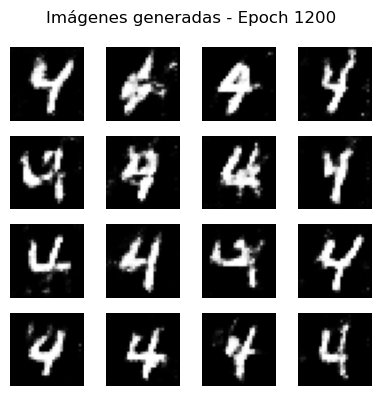

Epoch 1201
  D_real: 0.7109, D_fake: 0.7110, G: 1.0658
Epoch 1202
  D_real: 0.7111, D_fake: 0.7111, G: 1.0657
Epoch 1203
  D_real: 0.7111, D_fake: 0.7111, G: 1.0655
Epoch 1204
  D_real: 0.7112, D_fake: 0.7111, G: 1.0655
Epoch 1205
  D_real: 0.7112, D_fake: 0.7110, G: 1.0656
Epoch 1206
  D_real: 0.7111, D_fake: 0.7109, G: 1.0661
Epoch 1207
  D_real: 0.7109, D_fake: 0.7107, G: 1.0662
Epoch 1208
  D_real: 0.7107, D_fake: 0.7106, G: 1.0664
Epoch 1209
  D_real: 0.7105, D_fake: 0.7104, G: 1.0664
Epoch 1210
  D_real: 0.7103, D_fake: 0.7103, G: 1.0662
Epoch 1211
  D_real: 0.7102, D_fake: 0.7103, G: 1.0660
Epoch 1212
  D_real: 0.7102, D_fake: 0.7102, G: 1.0659
Epoch 1213
  D_real: 0.7102, D_fake: 0.7102, G: 1.0658
Epoch 1214
  D_real: 0.7102, D_fake: 0.7103, G: 1.0657
Epoch 1215
  D_real: 0.7103, D_fake: 0.7102, G: 1.0656
Epoch 1216
  D_real: 0.7103, D_fake: 0.7104, G: 1.0654
Epoch 1217
  D_real: 0.7105, D_fake: 0.7105, G: 1.0654
Epoch 1218
  D_real: 0.7106, D_fake: 0.7105, G: 1.0654
Epoch 1219

2025-04-23 17:48:24.966762: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


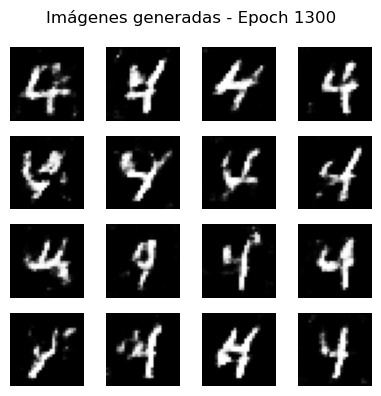

Epoch 1301
  D_real: 0.7083, D_fake: 0.7082, G: 1.0627
Epoch 1302
  D_real: 0.7082, D_fake: 0.7081, G: 1.0627
Epoch 1303
  D_real: 0.7081, D_fake: 0.7081, G: 1.0626
Epoch 1304
  D_real: 0.7081, D_fake: 0.7080, G: 1.0626
Epoch 1305
  D_real: 0.7080, D_fake: 0.7080, G: 1.0626
Epoch 1306
  D_real: 0.7080, D_fake: 0.7079, G: 1.0626
Epoch 1307
  D_real: 0.7079, D_fake: 0.7079, G: 1.0626
Epoch 1308
  D_real: 0.7079, D_fake: 0.7078, G: 1.0625
Epoch 1309
  D_real: 0.7078, D_fake: 0.7078, G: 1.0625
Epoch 1310
  D_real: 0.7078, D_fake: 0.7077, G: 1.0625
Epoch 1311
  D_real: 0.7078, D_fake: 0.7077, G: 1.0625
Epoch 1312
  D_real: 0.7077, D_fake: 0.7076, G: 1.0624
Epoch 1313
  D_real: 0.7077, D_fake: 0.7077, G: 1.0623
Epoch 1314
  D_real: 0.7077, D_fake: 0.7077, G: 1.0623
Epoch 1315
  D_real: 0.7077, D_fake: 0.7078, G: 1.0621
Epoch 1316
  D_real: 0.7078, D_fake: 0.7078, G: 1.0620
Epoch 1317
  D_real: 0.7079, D_fake: 0.7079, G: 1.0619
Epoch 1318
  D_real: 0.7080, D_fake: 0.7079, G: 1.0619
Epoch 1319

2025-04-23 17:48:37.378131: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


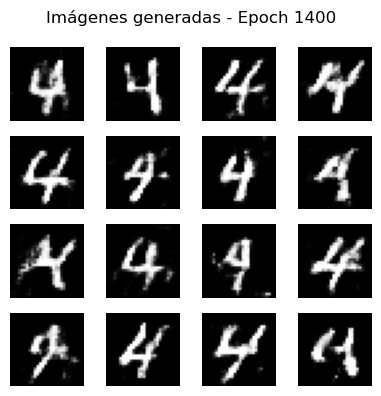

Epoch 1401
  D_real: 0.7056, D_fake: 0.7057, G: 1.0604
Epoch 1402
  D_real: 0.7058, D_fake: 0.7058, G: 1.0603
Epoch 1403
  D_real: 0.7058, D_fake: 0.7058, G: 1.0603
Epoch 1404
  D_real: 0.7058, D_fake: 0.7057, G: 1.0605
Epoch 1405
  D_real: 0.7057, D_fake: 0.7055, G: 1.0610
Epoch 1406
  D_real: 0.7056, D_fake: 0.7054, G: 1.0614
Epoch 1407
  D_real: 0.7053, D_fake: 0.7052, G: 1.0616
Epoch 1408
  D_real: 0.7051, D_fake: 0.7051, G: 1.0615
Epoch 1409
  D_real: 0.7050, D_fake: 0.7050, G: 1.0614
Epoch 1410
  D_real: 0.7049, D_fake: 0.7049, G: 1.0613
Epoch 1411
  D_real: 0.7049, D_fake: 0.7049, G: 1.0612
Epoch 1412
  D_real: 0.7049, D_fake: 0.7050, G: 1.0609
Epoch 1413
  D_real: 0.7050, D_fake: 0.7051, G: 1.0607
Epoch 1414
  D_real: 0.7052, D_fake: 0.7052, G: 1.0607
Epoch 1415
  D_real: 0.7052, D_fake: 0.7051, G: 1.0609
Epoch 1416
  D_real: 0.7052, D_fake: 0.7051, G: 1.0610
Epoch 1417
  D_real: 0.7051, D_fake: 0.7049, G: 1.0614
Epoch 1418
  D_real: 0.7049, D_fake: 0.7047, G: 1.0619
Epoch 1419

2025-04-23 17:48:50.766787: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


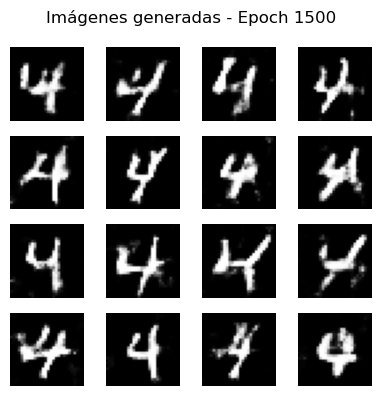

Epoch 1501
  D_real: 0.7029, D_fake: 0.7029, G: 1.0603
Epoch 1502
  D_real: 0.7029, D_fake: 0.7030, G: 1.0601
Epoch 1503
  D_real: 0.7031, D_fake: 0.7030, G: 1.0601
Epoch 1504
  D_real: 0.7031, D_fake: 0.7030, G: 1.0600
Epoch 1505
  D_real: 0.7031, D_fake: 0.7031, G: 1.0599
Epoch 1506
  D_real: 0.7031, D_fake: 0.7030, G: 1.0599
Epoch 1507
  D_real: 0.7030, D_fake: 0.7029, G: 1.0601
Epoch 1508
  D_real: 0.7029, D_fake: 0.7028, G: 1.0602
Epoch 1509
  D_real: 0.7028, D_fake: 0.7027, G: 1.0601
Epoch 1510
  D_real: 0.7027, D_fake: 0.7027, G: 1.0600
Epoch 1511
  D_real: 0.7027, D_fake: 0.7027, G: 1.0598
Epoch 1512
  D_real: 0.7028, D_fake: 0.7029, G: 1.0597
Epoch 1513
  D_real: 0.7029, D_fake: 0.7029, G: 1.0596
Epoch 1514
  D_real: 0.7030, D_fake: 0.7030, G: 1.0595
Epoch 1515
  D_real: 0.7030, D_fake: 0.7030, G: 1.0596
Epoch 1516
  D_real: 0.7031, D_fake: 0.7030, G: 1.0596
Epoch 1517
  D_real: 0.7030, D_fake: 0.7029, G: 1.0596
Epoch 1518
  D_real: 0.7029, D_fake: 0.7028, G: 1.0597
Epoch 1519

2025-04-23 17:49:04.100091: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


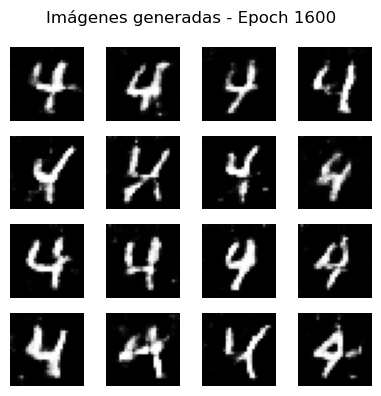

Epoch 1601
  D_real: 0.7009, D_fake: 0.7009, G: 1.0572
Epoch 1602
  D_real: 0.7009, D_fake: 0.7008, G: 1.0571
Epoch 1603
  D_real: 0.7009, D_fake: 0.7009, G: 1.0569
Epoch 1604
  D_real: 0.7010, D_fake: 0.7010, G: 1.0568
Epoch 1605
  D_real: 0.7010, D_fake: 0.7010, G: 1.0568
Epoch 1606
  D_real: 0.7011, D_fake: 0.7010, G: 1.0569
Epoch 1607
  D_real: 0.7010, D_fake: 0.7009, G: 1.0570
Epoch 1608
  D_real: 0.7009, D_fake: 0.7008, G: 1.0571
Epoch 1609
  D_real: 0.7008, D_fake: 0.7008, G: 1.0571
Epoch 1610
  D_real: 0.7008, D_fake: 0.7008, G: 1.0570
Epoch 1611
  D_real: 0.7008, D_fake: 0.7007, G: 1.0569
Epoch 1612
  D_real: 0.7008, D_fake: 0.7008, G: 1.0568
Epoch 1613
  D_real: 0.7008, D_fake: 0.7009, G: 1.0567
Epoch 1614
  D_real: 0.7009, D_fake: 0.7009, G: 1.0566
Epoch 1615
  D_real: 0.7009, D_fake: 0.7009, G: 1.0566
Epoch 1616
  D_real: 0.7009, D_fake: 0.7008, G: 1.0567
Epoch 1617
  D_real: 0.7008, D_fake: 0.7007, G: 1.0568
Epoch 1618
  D_real: 0.7007, D_fake: 0.7007, G: 1.0568
Epoch 1619

2025-04-23 17:49:17.594869: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


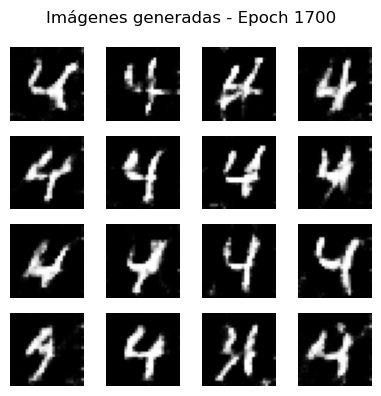

Epoch 1701
  D_real: 0.6987, D_fake: 0.6986, G: 1.0561
Epoch 1702
  D_real: 0.6986, D_fake: 0.6985, G: 1.0563
Epoch 1703
  D_real: 0.6985, D_fake: 0.6984, G: 1.0565
Epoch 1704
  D_real: 0.6983, D_fake: 0.6983, G: 1.0565
Epoch 1705
  D_real: 0.6983, D_fake: 0.6982, G: 1.0565
Epoch 1706
  D_real: 0.6982, D_fake: 0.6983, G: 1.0563
Epoch 1707
  D_real: 0.6983, D_fake: 0.6983, G: 1.0562
Epoch 1708
  D_real: 0.6983, D_fake: 0.6983, G: 1.0561
Epoch 1709
  D_real: 0.6984, D_fake: 0.6984, G: 1.0560
Epoch 1710
  D_real: 0.6984, D_fake: 0.6984, G: 1.0560
Epoch 1711
  D_real: 0.6984, D_fake: 0.6984, G: 1.0560
Epoch 1712
  D_real: 0.6984, D_fake: 0.6983, G: 1.0561
Epoch 1713
  D_real: 0.6984, D_fake: 0.6983, G: 1.0561
Epoch 1714
  D_real: 0.6983, D_fake: 0.6982, G: 1.0562
Epoch 1715
  D_real: 0.6982, D_fake: 0.6982, G: 1.0562
Epoch 1716
  D_real: 0.6982, D_fake: 0.6981, G: 1.0562
Epoch 1717
  D_real: 0.6981, D_fake: 0.6980, G: 1.0562
Epoch 1718
  D_real: 0.6980, D_fake: 0.6979, G: 1.0563
Epoch 1719

2025-04-23 17:49:30.195187: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


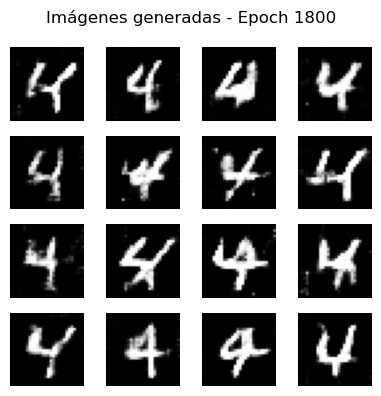

Epoch 1801
  D_real: 0.6958, D_fake: 0.6958, G: 1.0561
Epoch 1802
  D_real: 0.6958, D_fake: 0.6958, G: 1.0560
Epoch 1803
  D_real: 0.6959, D_fake: 0.6959, G: 1.0558
Epoch 1804
  D_real: 0.6959, D_fake: 0.6959, G: 1.0558
Epoch 1805
  D_real: 0.6960, D_fake: 0.6959, G: 1.0558
Epoch 1806
  D_real: 0.6959, D_fake: 0.6959, G: 1.0559
Epoch 1807
  D_real: 0.6959, D_fake: 0.6958, G: 1.0559
Epoch 1808
  D_real: 0.6958, D_fake: 0.6957, G: 1.0559
Epoch 1809
  D_real: 0.6957, D_fake: 0.6957, G: 1.0559
Epoch 1810
  D_real: 0.6957, D_fake: 0.6956, G: 1.0560
Epoch 1811
  D_real: 0.6957, D_fake: 0.6956, G: 1.0559
Epoch 1812
  D_real: 0.6957, D_fake: 0.6956, G: 1.0559
Epoch 1813
  D_real: 0.6956, D_fake: 0.6957, G: 1.0558
Epoch 1814
  D_real: 0.6957, D_fake: 0.6958, G: 1.0557
Epoch 1815
  D_real: 0.6959, D_fake: 0.6959, G: 1.0556
Epoch 1816
  D_real: 0.6959, D_fake: 0.6959, G: 1.0555
Epoch 1817
  D_real: 0.6959, D_fake: 0.6959, G: 1.0554
Epoch 1818
  D_real: 0.6961, D_fake: 0.6960, G: 1.0556
Epoch 1819

2025-04-23 17:49:42.750963: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


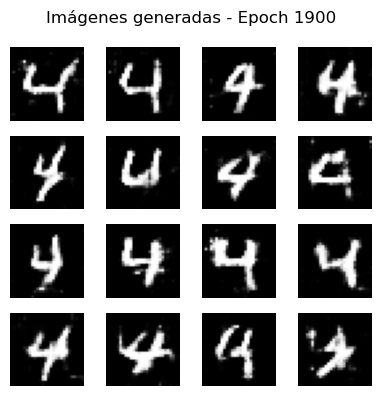

Epoch 1901
  D_real: 0.6932, D_fake: 0.6933, G: 1.0556
Epoch 1902
  D_real: 0.6933, D_fake: 0.6934, G: 1.0554
Epoch 1903
  D_real: 0.6934, D_fake: 0.6935, G: 1.0552
Epoch 1904
  D_real: 0.6935, D_fake: 0.6935, G: 1.0551
Epoch 1905
  D_real: 0.6936, D_fake: 0.6935, G: 1.0552
Epoch 1906
  D_real: 0.6936, D_fake: 0.6934, G: 1.0555
Epoch 1907
  D_real: 0.6935, D_fake: 0.6933, G: 1.0558
Epoch 1908
  D_real: 0.6934, D_fake: 0.6932, G: 1.0561
Epoch 1909
  D_real: 0.6932, D_fake: 0.6931, G: 1.0562
Epoch 1910
  D_real: 0.6930, D_fake: 0.6930, G: 1.0561
Epoch 1911
  D_real: 0.6929, D_fake: 0.6928, G: 1.0562
Epoch 1912
  D_real: 0.6928, D_fake: 0.6927, G: 1.0560
Epoch 1913
  D_real: 0.6927, D_fake: 0.6929, G: 1.0559
Epoch 1914
  D_real: 0.6929, D_fake: 0.6929, G: 1.0557
Epoch 1915
  D_real: 0.6930, D_fake: 0.6930, G: 1.0556
Epoch 1916
  D_real: 0.6930, D_fake: 0.6930, G: 1.0556
Epoch 1917
  D_real: 0.6931, D_fake: 0.6929, G: 1.0559
Epoch 1918
  D_real: 0.6930, D_fake: 0.6929, G: 1.0560
Epoch 1919

2025-04-23 17:49:55.161955: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


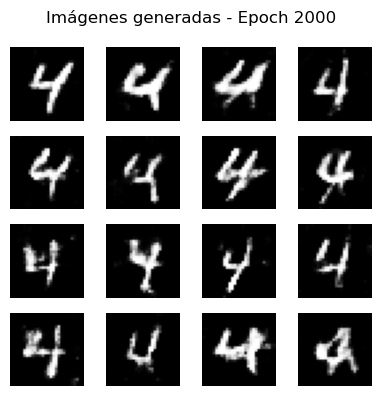

Epoch 2001
  D_real: 0.6914, D_fake: 0.6913, G: 1.0555
Epoch 2002
  D_real: 0.6913, D_fake: 0.6912, G: 1.0555
Epoch 2003
  D_real: 0.6912, D_fake: 0.6911, G: 1.0556
Epoch 2004
  D_real: 0.6911, D_fake: 0.6911, G: 1.0555
Epoch 2005
  D_real: 0.6911, D_fake: 0.6911, G: 1.0554
Epoch 2006
  D_real: 0.6911, D_fake: 0.6911, G: 1.0554
Epoch 2007
  D_real: 0.6911, D_fake: 0.6911, G: 1.0554
Epoch 2008
  D_real: 0.6911, D_fake: 0.6911, G: 1.0554
Epoch 2009
  D_real: 0.6911, D_fake: 0.6911, G: 1.0553
Epoch 2010
  D_real: 0.6911, D_fake: 0.6911, G: 1.0553
Epoch 2011
  D_real: 0.6911, D_fake: 0.6911, G: 1.0553
Epoch 2012
  D_real: 0.6911, D_fake: 0.6911, G: 1.0552
Epoch 2013
  D_real: 0.6911, D_fake: 0.6911, G: 1.0553
Epoch 2014
  D_real: 0.6910, D_fake: 0.6910, G: 1.0553
Epoch 2015
  D_real: 0.6910, D_fake: 0.6909, G: 1.0554
Epoch 2016
  D_real: 0.6910, D_fake: 0.6909, G: 1.0556
Epoch 2017
  D_real: 0.6909, D_fake: 0.6908, G: 1.0557
Epoch 2018
  D_real: 0.6907, D_fake: 0.6906, G: 1.0559
Epoch 2019

2025-04-23 17:50:07.533262: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


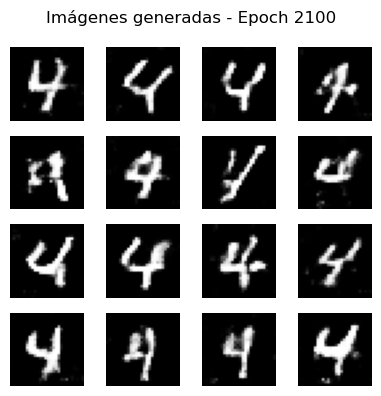

Epoch 2101
  D_real: 0.6883, D_fake: 0.6883, G: 1.0578
Epoch 2102
  D_real: 0.6882, D_fake: 0.6882, G: 1.0577
Epoch 2103
  D_real: 0.6882, D_fake: 0.6883, G: 1.0576
Epoch 2104
  D_real: 0.6883, D_fake: 0.6882, G: 1.0576
Epoch 2105
  D_real: 0.6883, D_fake: 0.6882, G: 1.0578
Epoch 2106
  D_real: 0.6882, D_fake: 0.6881, G: 1.0580
Epoch 2107
  D_real: 0.6881, D_fake: 0.6880, G: 1.0580
Epoch 2108
  D_real: 0.6880, D_fake: 0.6879, G: 1.0581
Epoch 2109
  D_real: 0.6879, D_fake: 0.6878, G: 1.0582
Epoch 2110
  D_real: 0.6878, D_fake: 0.6878, G: 1.0581
Epoch 2111
  D_real: 0.6878, D_fake: 0.6878, G: 1.0580
Epoch 2112
  D_real: 0.6878, D_fake: 0.6879, G: 1.0578
Epoch 2113
  D_real: 0.6880, D_fake: 0.6880, G: 1.0578
Epoch 2114
  D_real: 0.6880, D_fake: 0.6880, G: 1.0578
Epoch 2115
  D_real: 0.6880, D_fake: 0.6879, G: 1.0579
Epoch 2116
  D_real: 0.6879, D_fake: 0.6878, G: 1.0581
Epoch 2117
  D_real: 0.6878, D_fake: 0.6877, G: 1.0583
Epoch 2118
  D_real: 0.6876, D_fake: 0.6875, G: 1.0583
Epoch 2119

2025-04-23 17:50:20.652763: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


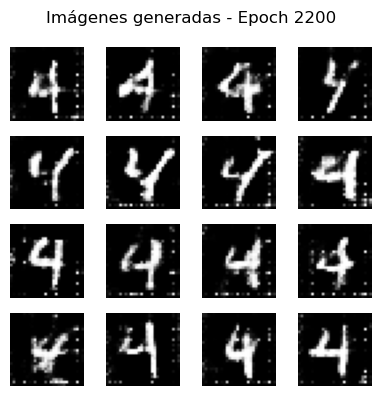

Epoch 2201
  D_real: 0.6857, D_fake: 0.6856, G: 1.0587
Epoch 2202
  D_real: 0.6856, D_fake: 0.6855, G: 1.0587
Epoch 2203
  D_real: 0.6855, D_fake: 0.6855, G: 1.0587
Epoch 2204
  D_real: 0.6855, D_fake: 0.6854, G: 1.0587
Epoch 2205
  D_real: 0.6854, D_fake: 0.6854, G: 1.0586
Epoch 2206
  D_real: 0.6855, D_fake: 0.6854, G: 1.0587
Epoch 2207
  D_real: 0.6854, D_fake: 0.6853, G: 1.0588
Epoch 2208
  D_real: 0.6853, D_fake: 0.6853, G: 1.0589
Epoch 2209
  D_real: 0.6853, D_fake: 0.6852, G: 1.0590
Epoch 2210
  D_real: 0.6852, D_fake: 0.6852, G: 1.0590
Epoch 2211
  D_real: 0.6852, D_fake: 0.6851, G: 1.0590
Epoch 2212
  D_real: 0.6851, D_fake: 0.6851, G: 1.0591
Epoch 2213
  D_real: 0.6851, D_fake: 0.6850, G: 1.0592
Epoch 2214
  D_real: 0.6850, D_fake: 0.6848, G: 1.0594
Epoch 2215
  D_real: 0.6848, D_fake: 0.6847, G: 1.0595
Epoch 2216
  D_real: 0.6847, D_fake: 0.6846, G: 1.0595
Epoch 2217
  D_real: 0.6846, D_fake: 0.6846, G: 1.0594
Epoch 2218
  D_real: 0.6845, D_fake: 0.6845, G: 1.0594
Epoch 2219

2025-04-23 17:50:33.412978: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


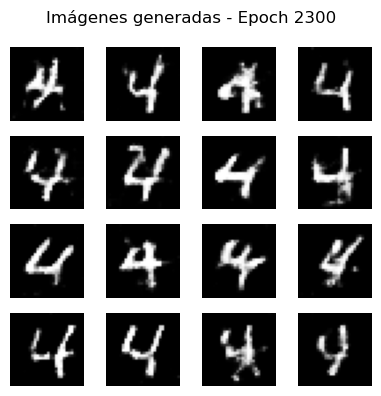

Epoch 2301
  D_real: 0.6812, D_fake: 0.6811, G: 1.0610
Epoch 2302
  D_real: 0.6811, D_fake: 0.6811, G: 1.0610
Epoch 2303
  D_real: 0.6811, D_fake: 0.6811, G: 1.0610
Epoch 2304
  D_real: 0.6811, D_fake: 0.6811, G: 1.0609
Epoch 2305
  D_real: 0.6811, D_fake: 0.6810, G: 1.0610
Epoch 2306
  D_real: 0.6811, D_fake: 0.6810, G: 1.0610
Epoch 2307
  D_real: 0.6811, D_fake: 0.6810, G: 1.0610
Epoch 2308
  D_real: 0.6810, D_fake: 0.6810, G: 1.0609
Epoch 2309
  D_real: 0.6810, D_fake: 0.6810, G: 1.0608
Epoch 2310
  D_real: 0.6811, D_fake: 0.6811, G: 1.0608
Epoch 2311
  D_real: 0.6812, D_fake: 0.6812, G: 1.0609
Epoch 2312
  D_real: 0.6812, D_fake: 0.6812, G: 1.0610
Epoch 2313
  D_real: 0.6812, D_fake: 0.6811, G: 1.0611
Epoch 2314
  D_real: 0.6810, D_fake: 0.6810, G: 1.0610
Epoch 2315
  D_real: 0.6810, D_fake: 0.6810, G: 1.0610
Epoch 2316
  D_real: 0.6810, D_fake: 0.6809, G: 1.0610
Epoch 2317
  D_real: 0.6809, D_fake: 0.6809, G: 1.0610
Epoch 2318
  D_real: 0.6810, D_fake: 0.6809, G: 1.0611
Epoch 2319

2025-04-23 17:50:46.142973: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


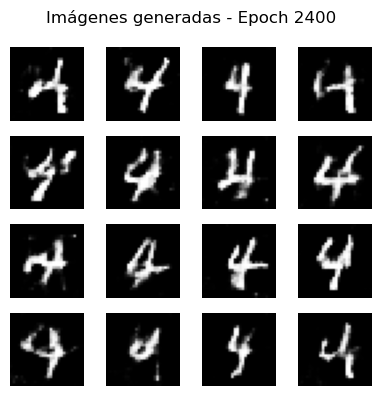

Epoch 2401
  D_real: 0.6794, D_fake: 0.6793, G: 1.0616
Epoch 2402
  D_real: 0.6793, D_fake: 0.6792, G: 1.0618
Epoch 2403
  D_real: 0.6792, D_fake: 0.6792, G: 1.0617
Epoch 2404
  D_real: 0.6792, D_fake: 0.6793, G: 1.0616
Epoch 2405
  D_real: 0.6793, D_fake: 0.6793, G: 1.0615
Epoch 2406
  D_real: 0.6793, D_fake: 0.6792, G: 1.0616
Epoch 2407
  D_real: 0.6793, D_fake: 0.6792, G: 1.0617
Epoch 2408
  D_real: 0.6792, D_fake: 0.6791, G: 1.0619
Epoch 2409
  D_real: 0.6790, D_fake: 0.6789, G: 1.0620
Epoch 2410
  D_real: 0.6789, D_fake: 0.6789, G: 1.0620
Epoch 2411
  D_real: 0.6789, D_fake: 0.6789, G: 1.0619
Epoch 2412
  D_real: 0.6788, D_fake: 0.6789, G: 1.0618
Epoch 2413
  D_real: 0.6789, D_fake: 0.6789, G: 1.0617
Epoch 2414
  D_real: 0.6790, D_fake: 0.6789, G: 1.0617
Epoch 2415
  D_real: 0.6790, D_fake: 0.6789, G: 1.0617
Epoch 2416
  D_real: 0.6789, D_fake: 0.6788, G: 1.0619
Epoch 2417
  D_real: 0.6788, D_fake: 0.6788, G: 1.0619
Epoch 2418
  D_real: 0.6788, D_fake: 0.6787, G: 1.0620
Epoch 2419

2025-04-23 17:50:58.785639: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


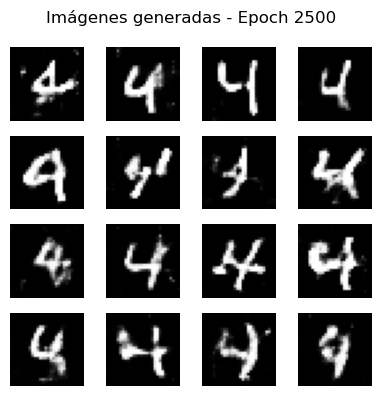

Epoch 2501
  D_real: 0.6769, D_fake: 0.6769, G: 1.0623
Epoch 2502
  D_real: 0.6769, D_fake: 0.6769, G: 1.0622
Epoch 2503
  D_real: 0.6768, D_fake: 0.6768, G: 1.0622
Epoch 2504
  D_real: 0.6769, D_fake: 0.6769, G: 1.0622
Epoch 2505
  D_real: 0.6769, D_fake: 0.6770, G: 1.0621
Epoch 2506
  D_real: 0.6770, D_fake: 0.6770, G: 1.0621
Epoch 2507
  D_real: 0.6770, D_fake: 0.6769, G: 1.0621
Epoch 2508
  D_real: 0.6770, D_fake: 0.6769, G: 1.0622
Epoch 2509
  D_real: 0.6768, D_fake: 0.6767, G: 1.0624
Epoch 2510
  D_real: 0.6767, D_fake: 0.6767, G: 1.0624
Epoch 2511
  D_real: 0.6766, D_fake: 0.6766, G: 1.0623
Epoch 2512
  D_real: 0.6766, D_fake: 0.6766, G: 1.0623
Epoch 2513
  D_real: 0.6766, D_fake: 0.6766, G: 1.0624
Epoch 2514
  D_real: 0.6766, D_fake: 0.6766, G: 1.0624
Epoch 2515
  D_real: 0.6765, D_fake: 0.6765, G: 1.0625
Epoch 2516
  D_real: 0.6765, D_fake: 0.6765, G: 1.0625
Epoch 2517
  D_real: 0.6765, D_fake: 0.6765, G: 1.0625
Epoch 2518
  D_real: 0.6764, D_fake: 0.6764, G: 1.0625
Epoch 2519

2025-04-23 17:51:11.518679: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


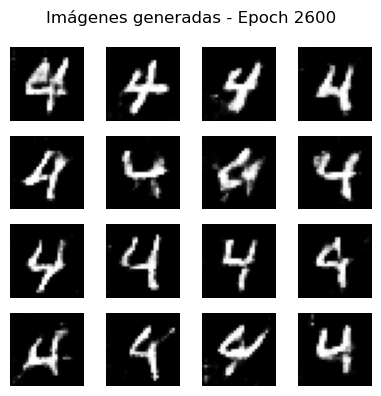

Epoch 2601
  D_real: 0.6749, D_fake: 0.6748, G: 1.0646
Epoch 2602
  D_real: 0.6748, D_fake: 0.6747, G: 1.0646
Epoch 2603
  D_real: 0.6747, D_fake: 0.6747, G: 1.0645
Epoch 2604
  D_real: 0.6747, D_fake: 0.6747, G: 1.0645
Epoch 2605
  D_real: 0.6747, D_fake: 0.6746, G: 1.0646
Epoch 2606
  D_real: 0.6746, D_fake: 0.6747, G: 1.0645
Epoch 2607
  D_real: 0.6747, D_fake: 0.6747, G: 1.0645
Epoch 2608
  D_real: 0.6747, D_fake: 0.6746, G: 1.0646
Epoch 2609
  D_real: 0.6746, D_fake: 0.6745, G: 1.0647
Epoch 2610
  D_real: 0.6745, D_fake: 0.6745, G: 1.0648
Epoch 2611
  D_real: 0.6744, D_fake: 0.6745, G: 1.0647
Epoch 2612
  D_real: 0.6745, D_fake: 0.6745, G: 1.0647
Epoch 2613
  D_real: 0.6745, D_fake: 0.6745, G: 1.0647
Epoch 2614
  D_real: 0.6745, D_fake: 0.6745, G: 1.0647
Epoch 2615
  D_real: 0.6745, D_fake: 0.6745, G: 1.0647
Epoch 2616
  D_real: 0.6745, D_fake: 0.6744, G: 1.0648
Epoch 2617
  D_real: 0.6745, D_fake: 0.6745, G: 1.0648
Epoch 2618
  D_real: 0.6745, D_fake: 0.6745, G: 1.0647
Epoch 2619

2025-04-23 17:51:24.524536: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


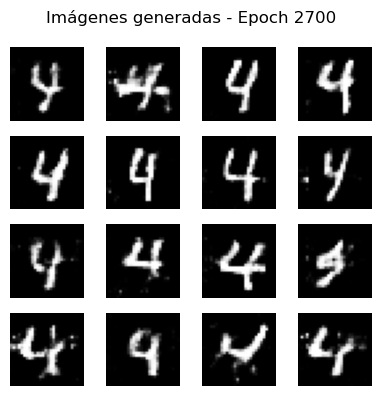

Epoch 2701
  D_real: 0.6723, D_fake: 0.6722, G: 1.0657
Epoch 2702
  D_real: 0.6722, D_fake: 0.6721, G: 1.0659
Epoch 2703
  D_real: 0.6721, D_fake: 0.6721, G: 1.0658
Epoch 2704
  D_real: 0.6721, D_fake: 0.6720, G: 1.0658
Epoch 2705
  D_real: 0.6720, D_fake: 0.6721, G: 1.0657
Epoch 2706
  D_real: 0.6721, D_fake: 0.6721, G: 1.0656
Epoch 2707
  D_real: 0.6721, D_fake: 0.6721, G: 1.0655
Epoch 2708
  D_real: 0.6722, D_fake: 0.6721, G: 1.0656
Epoch 2709
  D_real: 0.6722, D_fake: 0.6721, G: 1.0657
Epoch 2710
  D_real: 0.6721, D_fake: 0.6721, G: 1.0657
Epoch 2711
  D_real: 0.6721, D_fake: 0.6720, G: 1.0657
Epoch 2712
  D_real: 0.6720, D_fake: 0.6719, G: 1.0658
Epoch 2713
  D_real: 0.6719, D_fake: 0.6719, G: 1.0657
Epoch 2714
  D_real: 0.6719, D_fake: 0.6720, G: 1.0656
Epoch 2715
  D_real: 0.6720, D_fake: 0.6720, G: 1.0656
Epoch 2716
  D_real: 0.6720, D_fake: 0.6720, G: 1.0655
Epoch 2717
  D_real: 0.6721, D_fake: 0.6720, G: 1.0656
Epoch 2718
  D_real: 0.6720, D_fake: 0.6719, G: 1.0657
Epoch 2719

2025-04-23 17:51:37.426174: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


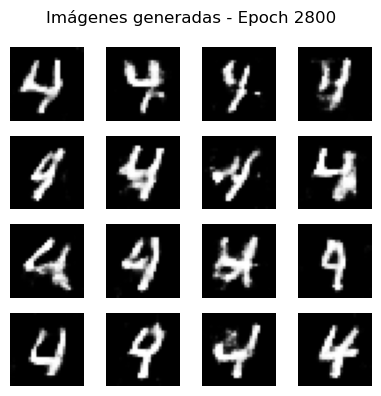

Epoch 2801
  D_real: 0.6689, D_fake: 0.6689, G: 1.0674
Epoch 2802
  D_real: 0.6690, D_fake: 0.6689, G: 1.0676
Epoch 2803
  D_real: 0.6689, D_fake: 0.6688, G: 1.0677
Epoch 2804
  D_real: 0.6688, D_fake: 0.6687, G: 1.0678
Epoch 2805
  D_real: 0.6687, D_fake: 0.6686, G: 1.0680
Epoch 2806
  D_real: 0.6685, D_fake: 0.6685, G: 1.0679
Epoch 2807
  D_real: 0.6685, D_fake: 0.6685, G: 1.0679
Epoch 2808
  D_real: 0.6684, D_fake: 0.6684, G: 1.0678
Epoch 2809
  D_real: 0.6685, D_fake: 0.6685, G: 1.0678
Epoch 2810
  D_real: 0.6684, D_fake: 0.6684, G: 1.0677
Epoch 2811
  D_real: 0.6684, D_fake: 0.6684, G: 1.0677
Epoch 2812
  D_real: 0.6684, D_fake: 0.6684, G: 1.0677
Epoch 2813
  D_real: 0.6684, D_fake: 0.6684, G: 1.0678
Epoch 2814
  D_real: 0.6684, D_fake: 0.6684, G: 1.0678
Epoch 2815
  D_real: 0.6683, D_fake: 0.6682, G: 1.0680
Epoch 2816
  D_real: 0.6682, D_fake: 0.6682, G: 1.0681
Epoch 2817
  D_real: 0.6682, D_fake: 0.6682, G: 1.0680
Epoch 2818
  D_real: 0.6682, D_fake: 0.6682, G: 1.0680
Epoch 2819

2025-04-23 17:51:50.042727: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


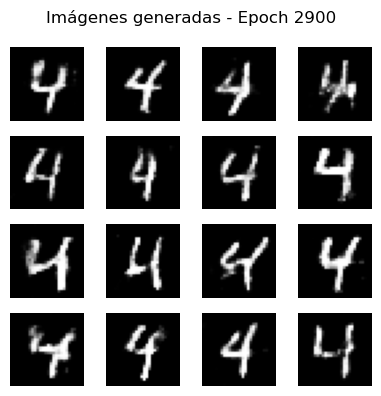

Modelo generador guardado en mejor_generador.h5


In [41]:
# Entrenamos hasta la mejor epoc
entrenar_gan_guardar(2900,"mejor_generador.h5")

In [42]:
def generar_y_visualizar_imagenes(ruta_generador, cantidad_imagenes=10, columnas=4):
    import math

    generador = keras.models.load_model(ruta_generador)

    # Creamos ruido para generar imágenes falsas
    ruido = np.random.normal(0, 1, (cantidad_imagenes, TAM_ENTRADA))

    # Generamos las imágenes
    imagenes_generadas = generador.predict(ruido)

    # Normalizamos imágenes de [-1, 1] a [0, 1] si es necesario
    imagenes_generadas = (imagenes_generadas + 1) / 2

    filas = math.ceil(cantidad_imagenes / columnas)
    fig, axs = plt.subplots(filas, columnas, figsize=(columnas * 2.5, filas * 2.5))
    axs = axs.ravel()

    for i in range(cantidad_imagenes):
        axs[i].imshow(imagenes_generadas[i, :, :, 0], cmap='gray')
        axs[i].axis('off')

    for i in range(cantidad_imagenes, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


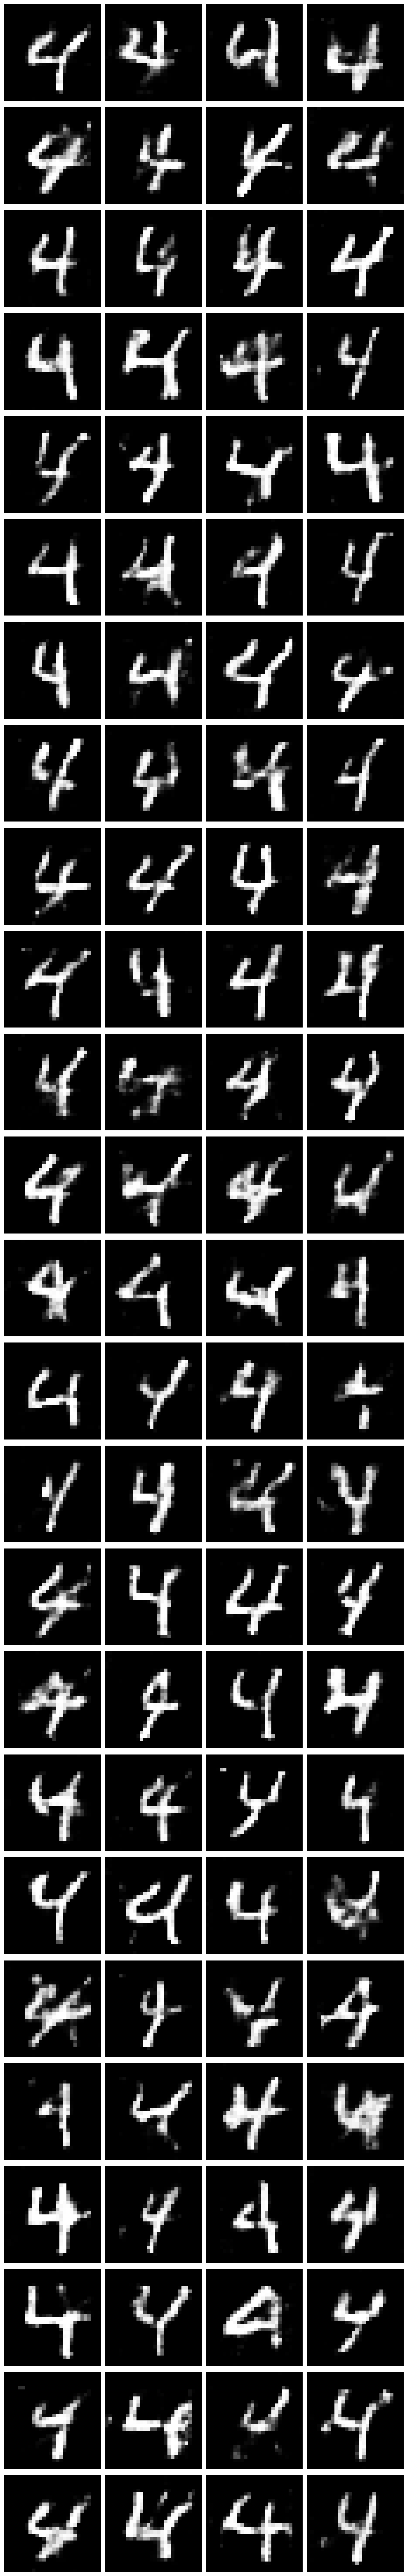

In [43]:
generar_y_visualizar_imagenes(r"mejor_generador.h5", 100)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from PIL import Image

def generar_y_guardar_imagenes(ruta_generador, carpeta_salida, cantidad_imagenes=4000, tam_entrada=100, prefijo_nombre="digito4"):
    # Crear carpeta de salida si no existe
    os.makedirs(carpeta_salida, exist_ok=True)

    # Cargar el modelo generador
    generador = keras.models.load_model(ruta_generador)

    # Generar ruido aleatorio
    ruido = np.random.normal(0, 1, (cantidad_imagenes, tam_entrada))

    # Generar imágenes
    imagenes_generadas = generador.predict(ruido)

    # Normalizar imágenes de [-1, 1] a [0, 1] si es necesario
    imagenes_generadas = (imagenes_generadas + 1) / 2.0

    for i in range(cantidad_imagenes):
        imagen = imagenes_generadas[i]

        # Eliminar canal si es solo 1 (grayscale)
        if imagen.shape[-1] == 1:
            imagen = imagen[:, :, 0]

        # Convertir a imagen tipo PIL
        imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))

        # Guardar imagen
        nombre_archivo = f"{prefijo_nombre}_{i}.png"
        ruta_archivo = os.path.join(carpeta_salida, nombre_archivo)
        imagen_pil.save(ruta_archivo)

    print(f"Se guardaron {cantidad_imagenes} imágenes en la carpeta: {carpeta_salida}")


In [45]:
generar_y_guardar_imagenes(
    ruta_generador="mejor_generador.h5",
    carpeta_salida="imagenes_generadas",
    cantidad_imagenes=4000,
    tam_entrada=100,  # Cambia esto si tu generador espera otra dimensión
    prefijo_nombre="digito4"
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Se guardaron 4000 imágenes en la carpeta: imagenes_generadas
